In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

To do:
1. Compare results for Markov chains (**done**, same results cause of $\hat{R} < 1.1$):
    1. median and std of all chains'values (**done**)
    2. mean of all chains of the mean value (**done**)
2. In analysis.py generalize of prior's distribution parameters (**no need**)
3. modulation of active cases of 7 days (monday), try to fit weekly mean data, change beta accordingly
4. Presentation title: something like "Limits of forecasting COVID-19 data"
5. Change the burn in size, so traces plot showing the burn in one and so I have to raise the number of iterations
6. R^2 adjusted (link)[https://medium.com/analytics-vidhya/measuring-the-goodness-of-fit-r%C2%B2-versus-adjusted-r%C2%B2-1e8ed0b5784a]
7. Implement Kolmogorov Smirnov test for goodness of fit (2 samples)
8. Solve problem of first two points in recovered+death variation plot
9. Add fit until 3 week post peak for first wave
10. Moving average starting from data != 0
<br> Optional:
    1. Add forecasting for t_peak (**done**)
    2. Add forecasting for end of end of epidemic (confirmed cases less then 1000 for the first time) (**done**)

In [3]:
import sys
import pandas as pd 
import numpy as np
import pyjags as pj
import arviz as az
from scipy import stats
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from datetime import datetime
import seaborn as sns
sys.path.append('modules/')
from analysis import Analysis

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image 


%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

#  Analytical solution of the SCIR model at low fraction of infected individuals

The SCIR model includes the usual states of an SIR model plus a new class C for individuals
sent to confinement that are susceptible but not infected.

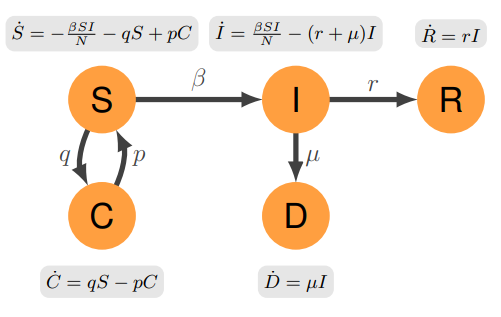

In [3]:
Image("SCIR_model.png")

Diagram of the epidemic model along with the equations ruling the dynamics. Susceptible individuals $(S)$ can enter and exit confinement $(C)$, or become infected $(I)$. Infected
individuals can recover $(R)$ or die $(D)$. $N$ is the total population. Rates for each process are
displayed in the figure, $q$ depends on specific measures restricting mobility, while $p$ stands for
individuals that leave the confinement measures (e.g. people working at essential jobs like food
supply, health care, policing) as well as for defection. We fit I to data on officially diagnosed
cases, which are automatically quarantined: the underlying assumption is that the real, mostly
undetected, number of infections is proportional to the diagnosed cases.
<br>

In a sufficiently large population, the number of infected individuals at the initial stages of the infection is well below the population size. Under certain conditions, it may stay small in
comparison to the number of susceptible individuals remaining. This seems to be the case for
several weeks of spread of COVID-19 in most countries.
If $I(t)/N \ll 1$, then the nonlinear term in the equation for the number of susceptible
individuals can be neglected. Within this approximation, the equations determining the dynamics are


$$\left\{\begin{array}
\dot \dot{S} = -qS + pC, \\
\dot{C} = qS - pC, \\
\dot{I} = \frac{\beta}{N}SI - (r+\mu)I, \\
\dot{R} = rI, \\
\dot{D} = \mu I.  \\
\end{array}\right.$$


The first two equations imply $S + C = N$, so $C = N − S$ and reformulate the equations as

$$\left\{\begin{matrix}
\dot{S} = -(q+p)S + pN, \\
\dot{I} = \frac{\beta}{N}IS - (r+\mu)I, \\
\end{matrix}\right.$$

The solution of this system can be obtained in closed form as

\begin{array}[]
SS(t) = \frac{N}{q+p}[p+qe^{-(p+q)t}], & R(t)=r\int_{0}^{t}I(u)du,\\
I(t)=I_{0}e^{[R^*_0(t)-1](r+\mu)t}, & D(t)=\mu\int_{0}^{t}I(u)du,\\
\end{array}

where
\begin{array}[]
RR^*_0(t) = \frac{R_0}{q+p}[p+q\frac{1-e^{-(p+q)t}}{(q+p)t}], & R_0=\frac{\beta}{r+\mu}\\
\end{array}

is the $\textit{effective basic reproduction number}$ modulated by the confinement, $R_0$ being its value at the beginning of the
epidemic.

## Fit a parametric Bayesian model


Simultaneously fit the number of active cases (I) and the
new number of cases in the interval ∆t = 1 day of recovered (R) and dead (D) cases in logarithmic scale—a linear scale
would give a biased larger weight to later times.
<br>

Variables:

\begin{array}[lll]
 llogI(t) \sim N(logI(t_0) + [\beta − (r + \mu)](t − t_0), \sigma_I),& t_0 < t ≤ t_q, & \mbox{(before confinement measure)}\\ 
 logI(t) \sim N(logI(t_q) + [R^*_0(t − t_q)−1](r + \mu)(t − t_q), \sigma_I),& t_q < t, & \mbox{(after confinement measure)}\\ 
 logX(t) \sim N(log(r + \mu) + logI(t), \sigma_X),& t > t_{X_{0}} &
\end{array}

where $X(t)$ = $\Delta$ $R(t)$ + $\Delta$ $D(t)$ is the change in the number of recovered plus dead cases daily reported.
Priors

\begin{array}
\beta\beta ∼ U(0,1), & 1/\sigma^2_I ∼ \Gamma(0.01,0.01), \\
r + \mu ∼ U(0,1), & 1/σ^2_X ∼ \Gamma(0.01,0.01), \\ 
p ∼ U(0,5), \\
q ∼ U(0,5)
\end{array}

where ∼ stands for distributed as, and $N$, $U$ and $Γ$ stand for Normal, Uniform and Gamma distributions. $t_0$ and $t_{X_{0}}$ stand for the days (since February 28th) where the first Infected and Recovered+Death cases were reported, respectively.
<br>
<br>
This model fit directly the solution of the deterministic model.
<br>
The priors for $\beta$ and $r + \mu$ are informative priors derived from the fact that in every country where cases of
coronavirus are detected, the doubling period at the very early stages of the epidemic was never smaller than two days.
Hence we have taken for these parameters a prior U(0,1) ($\beta < 1$). For the other parameters we assume a non-informative prior
U(0,5) (changes faster than 1/5 day are meaningless in any compartmental model).

# Dataset Spain
After the 18th of May the Spanish government stopped publishing data about recovered

In [5]:
# data until 17 may
url = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/covid-19-es.csv"
# data until 31 march
url_confirmed = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/confirmed-march31.csv"
url_recovered = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/recovered-march31.csv"
url_death = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/deaths-march31.csv"

df = pd.read_csv(url, keep_date_col=True)
df = df[~df.isna().any(axis=1)].reset_index(drop=True)
df['Day'] = pd.date_range(start="2020.01.31", end="2020.05.17")
df['Day'] = pd.to_datetime(df.Day, format='%Y-%m-%d').dt.strftime('%Y.%m.%d')

df.loc[(df.Day <= "2020.03.31") & (df.Day >= "2020.02.27"), ['Death', 'Confirmed', 'Recovered']] = np.column_stack([pd.read_csv(url_death)['Spain'],
                                                                        pd.read_csv(url_confirmed)['Spain'],
                                                                        pd.read_csv(url_recovered)['Spain']])
df['Confirmed'] = df.Confirmed - df.Recovered - df.Death
df['Confirmed_smooth'] = df.Confirmed.rolling(2, min_periods=1).mean()
df['Recovered_Death'] = (df.Recovered + df.Death).diff().fillna(0) # (daily derivative)
df['Recovered_Death_smooth'] = df.Recovered_Death.rolling(2, min_periods=1).mean()

df = df[df.Day >= '2020.02.28'].reset_index(drop=True)
df

Day    Death  Confirmed  Recovered  Confirmed_smooth  \
0   2020.02.28      0.0       32.0        0.0              24.0   
1   2020.02.29      0.0       44.0        0.0              38.0   
2   2020.03.01      0.0       66.0        0.0              55.0   
3   2020.03.02      0.0      114.0        0.0              90.0   
4   2020.03.03      0.0      150.0        0.0             132.0   
..         ...      ...        ...        ...               ...   
75  2020.05.13  27091.0    60777.0   140823.0           61570.0   
76  2020.05.14  27308.0    58858.0   143374.0           59817.5   
77  2020.05.15  27449.0    57951.0   144783.0           58404.5   
78  2020.05.16  27549.0    56703.0   146446.0           57327.0   
79  2020.05.17  27634.0    54140.0   149576.0           55421.5   

    Recovered_Death  Recovered_Death_smooth  
0               0.0                    -1.5  
1               0.0                     0.0  
2               0.0                     0.0  
3               0.0                     0.0  
4               0.0                     0.0  
..              ...                     ...  
75           2025.0                  2019.0  
76           2768.0                  2396.5  
77           1550.0                  2159.0  
78           1763.0                  1656.5  
79           3215.0                  2489.0  

[80 rows x 7 columns]

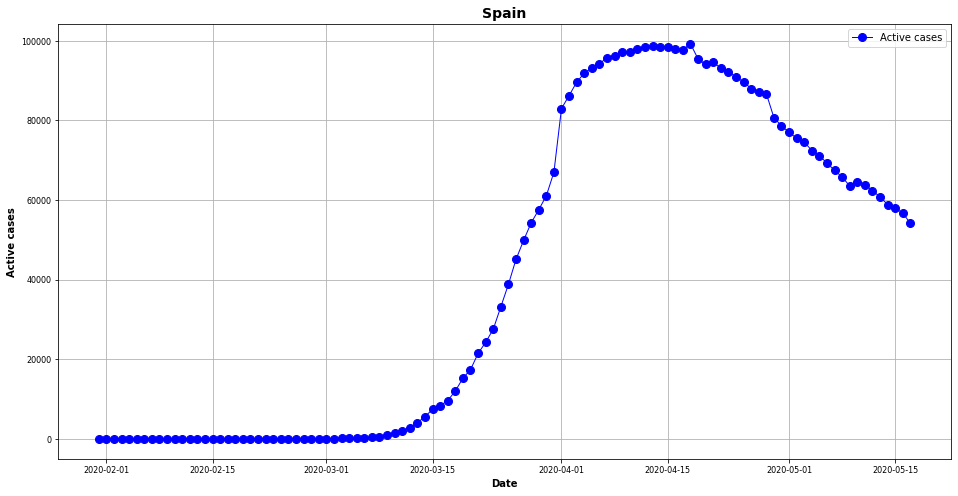

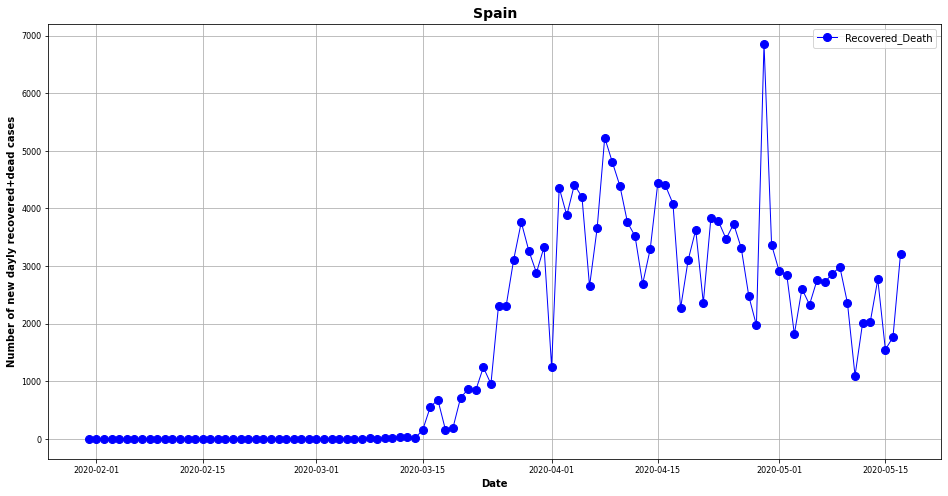

In [4]:
# save fgure with plot from january
plt.plot(pd.to_datetime(df.Day), df.Confirmed, 'bo-', lw=1, label='Active cases')
#plt.plot(pd.to_datetime(df.Day), df.Confirmed_smooth, 'r', lw=2, label='Active cases (2-days rolling average)')
#ymin, ymax = plt.ylim()
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.02.28']), 0, ymax, color='r')
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.03.31']), 0, ymax, color='g')
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.04.18']), 0, ymax, color='r')
plt.xlabel('Date')
plt.ylabel('Active cases')
plt.title('Spain', weight='bold', fontsize=14)
plt.legend()
plt.grid()
plt.savefig("active_cases_data_Spain.png", quality=100, transparent=True, dpi=400)
plt.show()


plt.plot(pd.to_datetime(df.Day), df.Recovered_Death, 'bo-', lw=1, label='Recovered_Death')
#plt.plot(pd.to_datetime(df.Day), df.Recovered_Death_smooth, 'r', lw=2, label='Recovered_Death (2-days rolling average)')
#ymin, ymax = plt.ylim()
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.02.28']), 0, ymax, color='r')
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.03.31']), 0, ymax, color='g')
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.04.18']), 0, ymax, color='r')
plt.xlabel('Date')
plt.ylabel('Number of new dayly recovered+dead cases')
plt.title('Spain', weight='bold', fontsize=14)
plt.legend()
plt.grid()
plt.savefig("recovered_death_data_Spain.png", quality=100, transparent=True, dpi=400)

## Fit ending before peak data
fit from 2020-02-27 to 2020-03-29 with confinement measure aplied on 2020-03-11

In [6]:
# instantiating an analysis object
analysis_esp = Analysis(date=df['Day'].to_numpy(),
                        confirmed=df['Confirmed'].to_numpy(),
                        recovered_death=df['Recovered_Death'].to_numpy(),
                        quarantine='2020.03.09',
                        last_data='2020.03.29',
                        last_projection='2020.05.17',
                        peak='2020.04.18',
                        beta=[0,1],
                        rmu=[0,1],
                        q=[0,5],
                        p=[0,5],
                        tauI=[0.01, 0.01],
                        tauX=[0.01, 0.01],
                        country='Spain')

AttributeError: 'Analysis' object has no attribute 'data'

In [5]:
%%time
# call sampler analysis' method
analysis_esp.sampler(nchains=12, nthreads=12, niter=10000, burn_in=0.5)

sampling: iterations 120000 of 120000, elapsed 0:00:03, remaining 0:00:00
CPU times: user 21 s, sys: 906 ms, total: 21.9 s
Wall time: 3.86 s


In [6]:
analysis_esp.summary

median       sd  2.5%_hdi  97.5%_hdi   r_hat
beta   0.3698   0.0080    0.3551     0.3867  1.0019
rmu    0.0203   0.0050    0.0130     0.0328  1.0016
q      0.0551   0.0047    0.0480     0.0667  1.0030
p      0.0069   0.0093    0.0003     0.0339  1.0019
tauI  57.0560  16.1140   31.2972    94.3140  1.0003
tauX   0.7676   0.2291    0.4051     1.2925  1.0001

Where

$$\hat{R} = \sqrt{\frac{\hat{V}}{W}}$$ is the **potential scale reduction factor**
<br>
<br>
- &emsp; **W** is the within-chain variance (mean of variance of each chain),
<br>
- &emsp; $\hat{V}$ is the variance between multiple chains.
<br>
<br>
This is the potential scale reduction factor, which converges to unity when each of the traces is a sample from the target posterior.
<br>
Values greater than one indicate that one or more chains have not yet converged.
<br> The simulation was runned until the $\hat{R}$ of each parameter was < 1.01.

In [7]:
# Compute the median and std of sigmaI and sigmaX

tauI = analysis_esp.samples['tauI'].ravel()
std_I = np.power(tauI, -1/2)
sd_std_I = np.std(std_I)
std_I = np.median(std_I)

tauX = analysis_esp.samples['tauX'].ravel()
std_X = np.power(tauX, -1/2)
sd_std_X = np.std(std_X)
std_X = np.median(std_X)

std_I, sd_std_I, std_X, sd_std_X

(0.13233141832592374,
 0.01956790085948724,
 1.1414538018831433,
 0.17693107214948212)

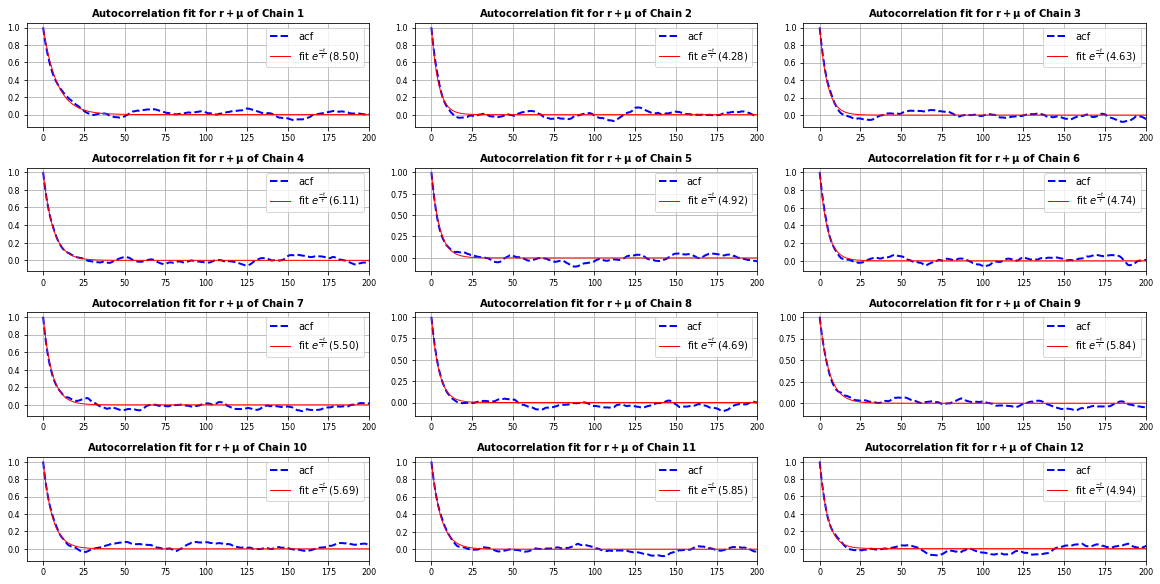

In [8]:
analysis_esp.autocorr_fit_plot(var='rmu')

(533.5380017653955, 10670.760035307909, 0.27428085363012916)

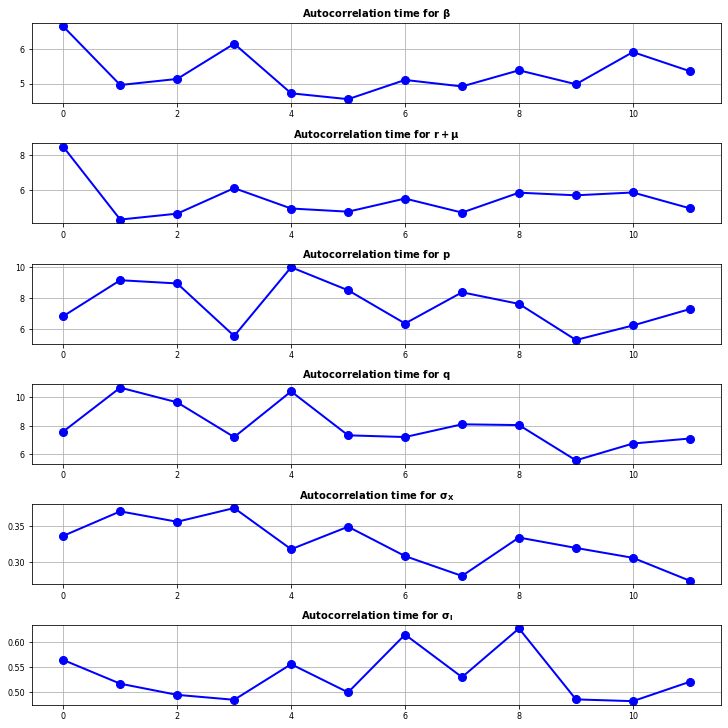

In [9]:
analysis_esp.autocorrelation_time_plot()
analysis_esp.times.max()*50, analysis_esp.times.max()*1000, analysis_esp.times.min()

### Posterior of the time to reach the peak of the epidemic

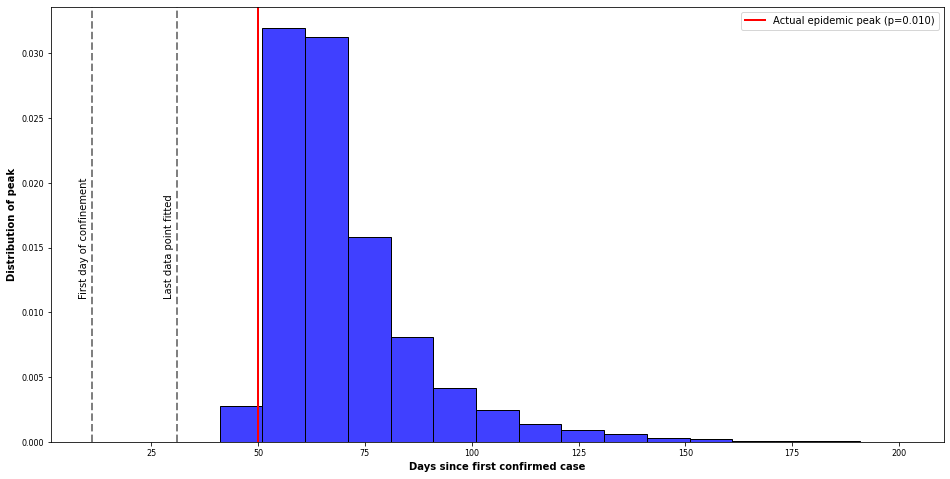

In [10]:
analysis_esp.peak_posterior()

analysis_esp.traces.to_csv('data.csv', index=False)

### Kolmogorov smirnov test for goodness of fit

Ks_2sampResult(statistic=0.41935483870967744, pvalue=0.007945718302533482)
0.997575288593993


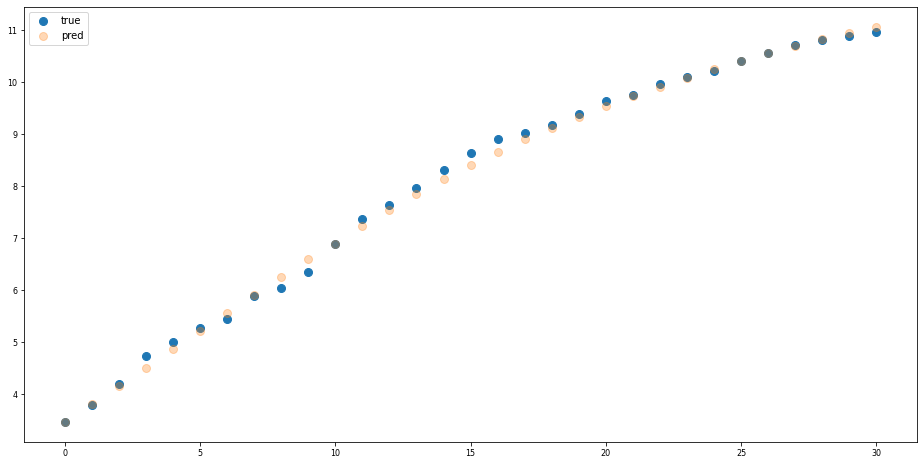

In [11]:
I = analysis_esp.data['I']
t0 = analysis_esp.data['t0'] - 1
tmax = analysis_esp.data['tmax']
I_exact = analysis_esp.infected_exact

y_true = I[t0:tmax]
y_pred = I_exact[t0:tmax]

from scipy import stats
from scipy.stats import ks_2samp

test = ks_2samp(y_true+2, y_pred)
print(test)
print((stats.linregress(y_true, y_pred)[2]) ** 2)


plt.scatter(np.arange(len(y_true)), y_true, label='true')
plt.scatter(np.arange(len(y_pred)), y_pred, label='pred', alpha=0.3)
plt.legend()


### Trace, posterior distribution, autocorrelation plot before peak (Spain)

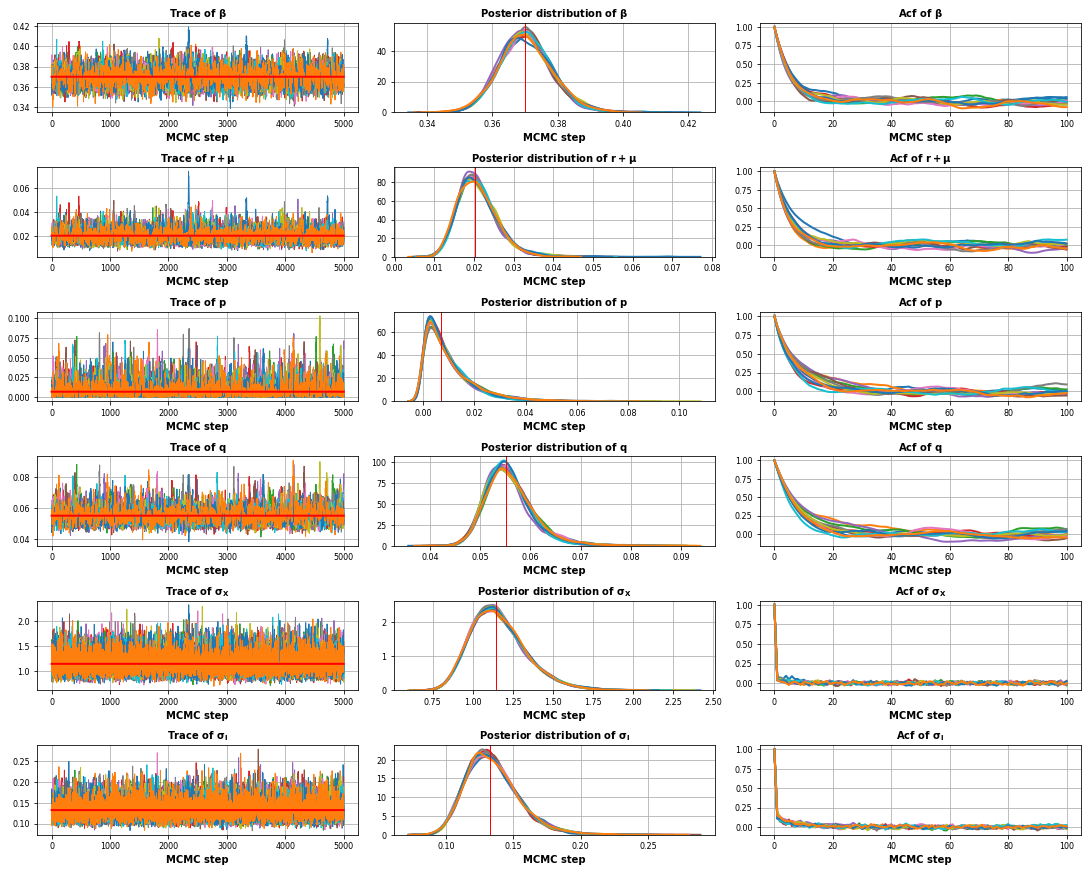

In [12]:
analysis_esp.plot_summary()

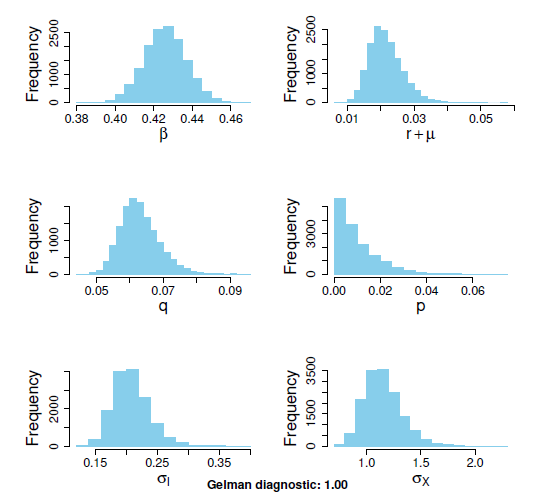

In [112]:
Image("../Immagini/Posterior Distribution paper.png")

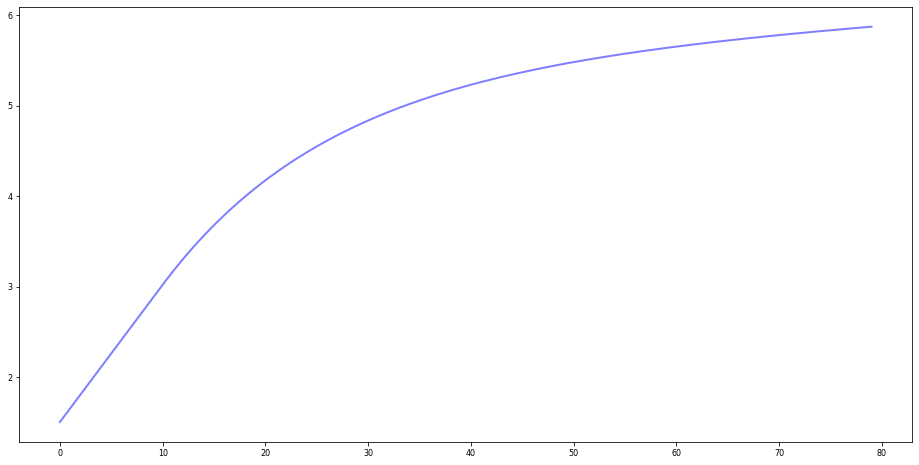

In [13]:
t_esp, *states_esp = analysis_esp.solve_SCIR()
plt.plot(t_esp, np.log(states_esp[2]) / np.log(10), 'b', alpha=0.5, lw=2, label='simulated')

### Plotting fit results before peak

In [ ]:
def doubling_time(self, tf=60, taud=2):
    N0 = np.exp(self.data['I0'])
    t = np.arange(tf)
    Nt = np.log(N0) + t / taud * np.log(2)

    plt.plot(t, Nt / np.log(10), '--', c='gray')
    return Nt

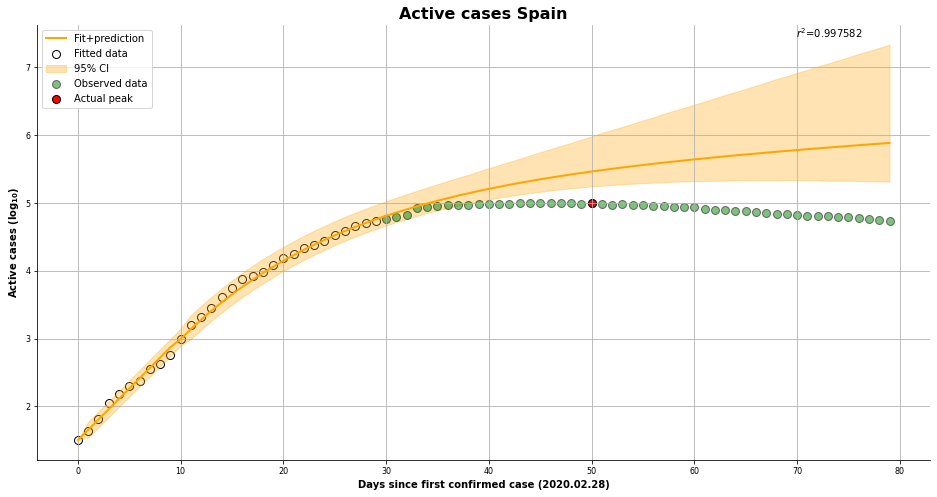

In [9]:
analysis_esp.plot_results(Y=True, observed=True)
#ax.plot(t_esp, np.log(SCIX_esp[2])/np.log(10), 'b', alpha=0.5, lw=2, label='simulated')    
#doubling_time(analysis_esp, taud=2);
#plt.plot(t_esp, np.log(SCIX_esp[2])/np.log(10), 'b', alpha=0.5, lw=2, label='simulated')
#plt.savefig("active_cases_Spain.png", quality=100, transparent=True, dpi=400)

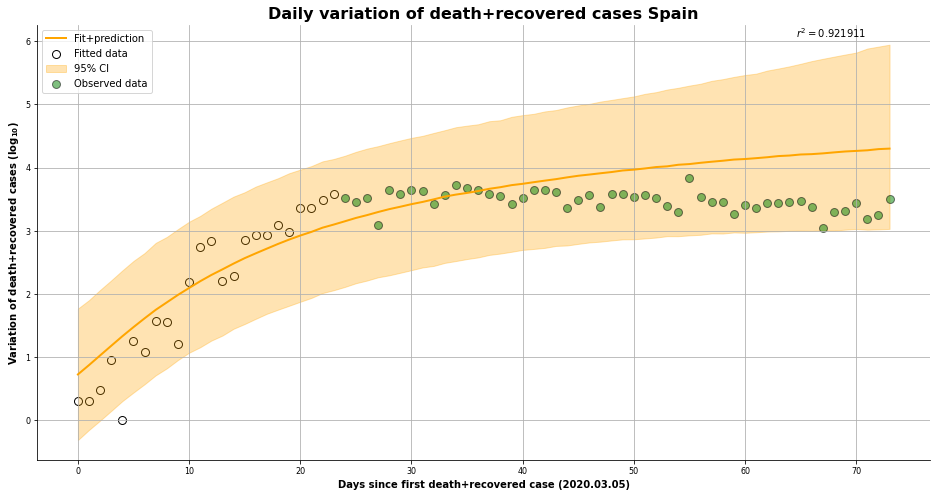

In [10]:
analysis_esp.plot_results(Z=True, observed=True)
#plt.plot(t_esp[:], np.log(SCIX_esp[3])/np.log(10), 'b', alpha=0.5, lw=2, label='simulated')
#plt.savefig("death_recovered_Spain.png", quality=100, transparent=True, dpi=400)

## Fit ending after peak data for the daily number of active cases

In [5]:
analysis_esp_2 = Analysis(date=df['Day'].to_numpy(),
                          confirmed=df['Confirmed'].to_numpy(),
                          recovered_death=df['Recovered_Death'].to_numpy(),
                          quarantine='2020.03.09',
                          last_data='2020.04.18',
                          last_projection='2020.05.17',
                          peak='2020.04.18',
                          beta=[0,1],
                          rmu=[0,1],
                          q=[0,5],
                          p=[0,5],
                          tauI=[0.01, 0.01],
                          tauX=[0.01, 0.01],
                          country='Spain')

In [6]:
%%time
# call sampler analysis' method
analysis_esp_2.sampler(nchains=12, nthreads=12, niter=30000, burn_in=0.5)

sampling: iterations 19928 of 360000, elapsed 0:00:07, remaining 0:02:07
sampling: iterations 176641 of 360000, elapsed 0:00:13, remaining 0:00:13
sampling: iterations 360000 of 360000, elapsed 0:00:17, remaining 0:00:00
CPU times: user 2min 11s, sys: 2.44 s, total: 2min 13s
Wall time: 19.4 s


In [6]:
%%time

analysis_esp_2.summary

CPU times: user 6.72 s, sys: 250 ms, total: 6.97 s
Wall time: 6.96 s


median       sd  2.5%_hdi  97.5%_hdi   r_hat
beta   0.3973   0.0073    0.3839     0.4130  1.0022
rmu    0.0321   0.0059    0.0237     0.0471  1.0046
q      0.0599   0.0023    0.0550     0.0643  1.0042
p      0.0004   0.0005    0.0000     0.0019  1.0002
tauI  49.9413  11.2169   31.6764    75.4822  1.0008
tauX   1.0859   0.2519    0.6582     1.6430  1.0011

### Trace, posterior distribution, autocorrelation plot after peak (Spain)

CPU times: user 4.09 s, sys: 109 ms, total: 4.2 s
Wall time: 4.09 s


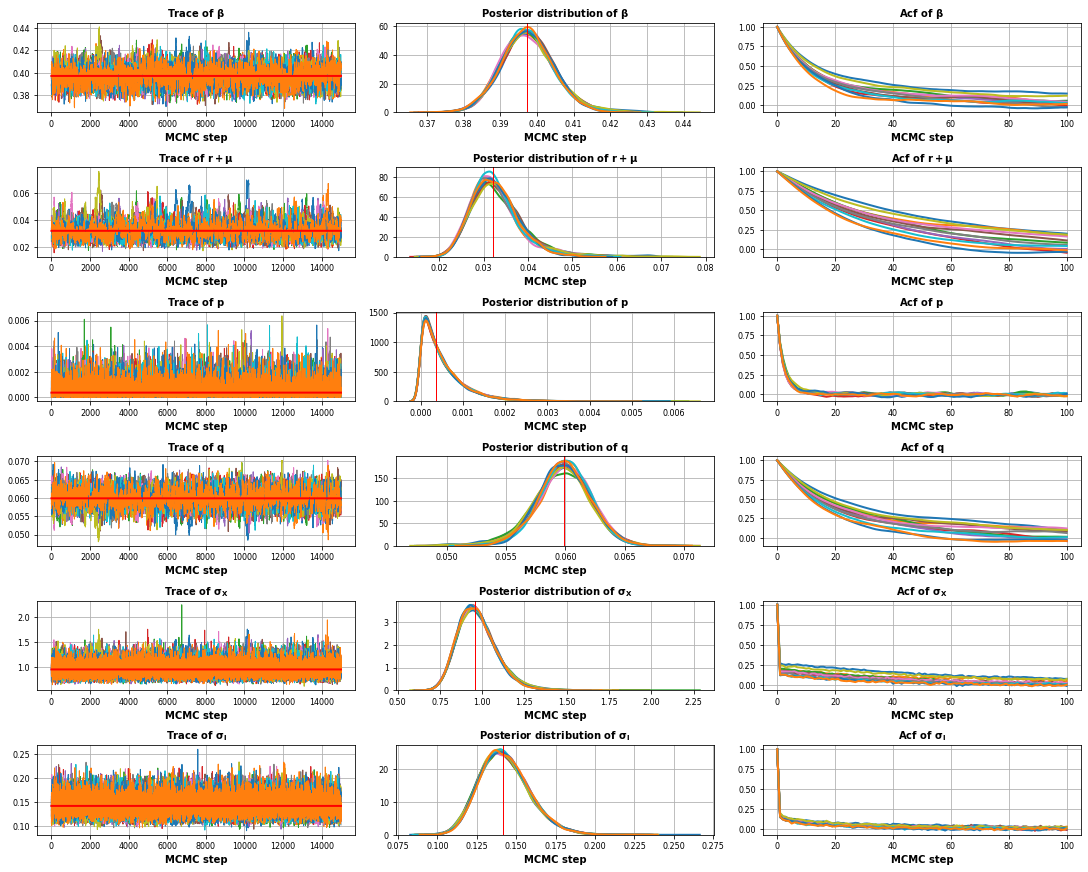

In [7]:
%%time

analysis_esp_2.plot_summary()

(2901.0920993835166, 58021.84198767033)

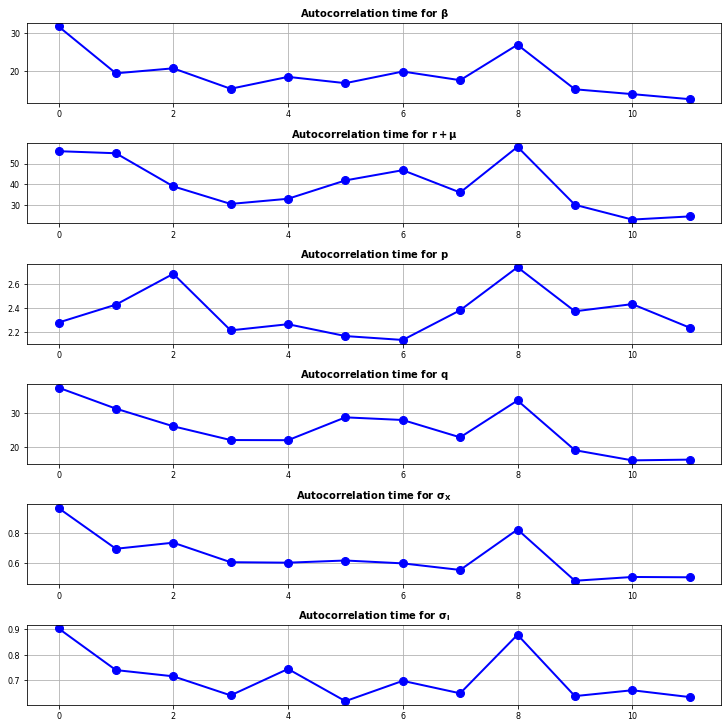

In [8]:
analysis_esp_2.autocorrelation_time_plot()
analysis_esp_2.times.max()*50, analysis_esp_2.times.max()*1000

### Distribution of times until the number of confirmed cases falls below 1000 for the first time (Spain)

CPU times: user 1.97 s, sys: 3.03 s, total: 5 s
Wall time: 4.98 s


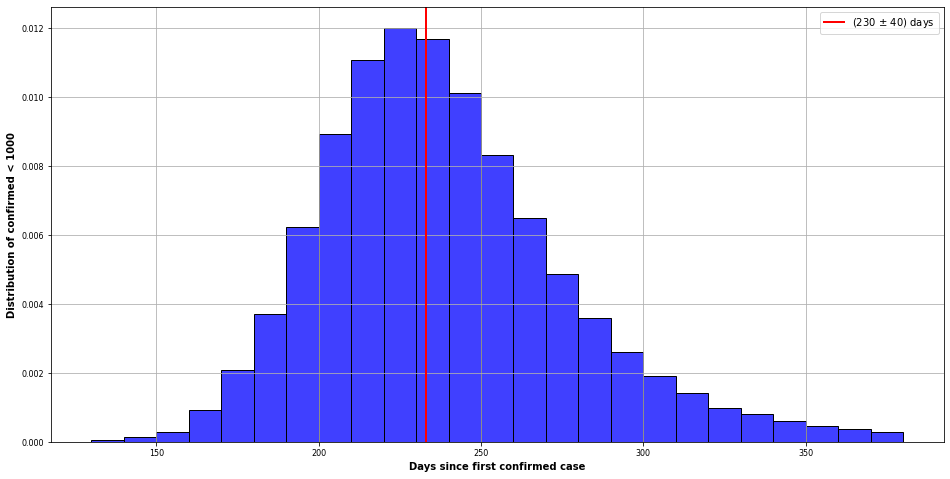

In [7]:
%%time

# 2021.03.14 :380 dqys since first data point
analysis_esp_2.end_epidemic_plot(tf='2021.03.14')

### Plotting fit results after peak

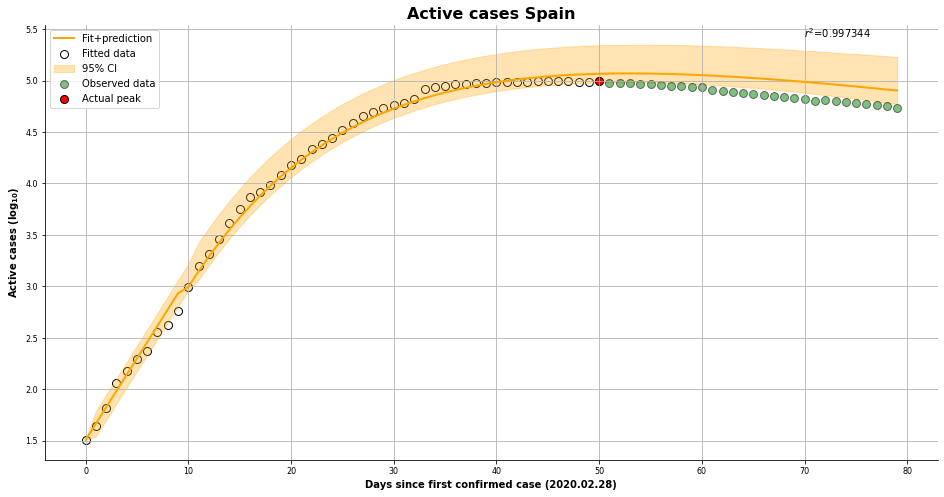

In [10]:
analysis_esp_2.plot_results(Y=True, observed=True)
ax = plt.gca()
#plt.xlim(-4.5, 80)
#plt.set_ylim(1, 6)

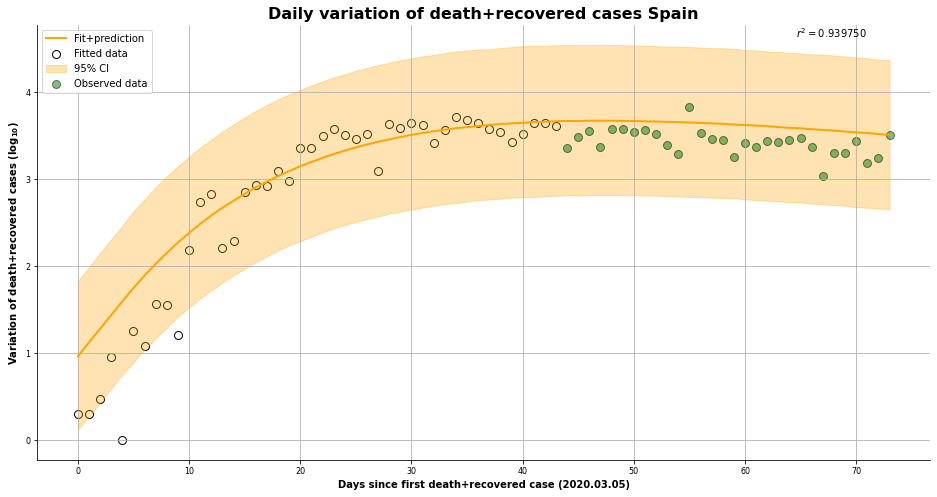

In [11]:
analysis_esp_2.plot_results(Z=True, observed=True)
#plt.xlim(-4.5, 80)
#plt.ylim(1, 6);

# Dataset Italy
The data is taken from Protezione Civile site, starting from 2020.02.24.

In [4]:
# dataset active cases
# all data from 2020-02-28 to today
url_ita = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento" + \
            "-nazionale/dpc-covid19-ita-andamento-nazionale.csv"

df1 = pd.read_csv(url_ita)[['data', 'totale_casi', 'dimessi_guariti', 'deceduti']]
df1.columns = ['Day', 'Confirmed', 'Recovered', 'Death']
df1['Day'] = pd.to_datetime(df1.Day, format='%Y.%m.%d').dt.strftime('%Y.%m.%d')


df1['Confirmed'] = df1.Confirmed - df1.Recovered - df1.Death
df1['Confirmed_smooth'] = df1.Confirmed.rolling(7, min_periods=1).mean()
df1['Recovered_Death'] = (df1.Recovered + df1.Death).diff().fillna(0) # (daily derivative)
df1['Recovered_Death_smooth'] = df1.Recovered_Death.rolling(7, min_periods=1).mean()


df1

Day  Confirmed  Recovered   Death  Confirmed_smooth  \
0    2020.02.24        221          1       7        221.000000   
1    2020.02.25        311          1      10        266.000000   
2    2020.02.26        385          3      12        305.666667   
3    2020.02.27        588         45      17        376.250000   
4    2020.02.28        821         46      21        465.200000   
..          ...        ...        ...     ...               ...   
398  2021.03.28     573235    2850889  107933     565687.285714   
399  2021.03.29     565993    2870614  108350     566105.285714   
400  2021.03.30     562832    2889301  108879     566416.428571   
401  2021.03.31     561277    2913045  109346     566412.000000   
402  2021.04.01     563479    2933757  109847     566486.428571   

     Recovered_Death  Recovered_Death_smooth  
0                0.0                0.000000  
1                3.0                1.500000  
2                4.0                2.333333  
3               47.0               13.500000  
4                5.0               11.800000  
..               ...                     ...  
398          18247.0            22016.857143  
399          20142.0            20164.857143  
400          19216.0            19888.285714  
401          24211.0            20405.285714  
402          21213.0            20273.857143  

[403 rows x 7 columns]

In [143]:
# Try to remove baseline of active cases and recovered+death cases
#df1.loc[df1.Day > '2020.08.27', 'Confirmed_smooth'] -= df1.loc[df1.Day == '2020.08.27', 'Confirmed_smooth'].to_numpy()
#df1.loc[df1.Day > '2020.08.27', 'Recovered_Death_smooth'] -= df1.loc[df1.Day == '2020.08.27', 'Recovered_Death'].to_numpy()
df1

Day  Confirmed  Recovered  Death  Confirmed_smooth  \
0    2020.02.26        385          3     12        305.666667   
1    2020.02.27        588         45     17        376.250000   
2    2020.02.28        821         46     21        465.200000   
3    2020.02.29       1049         50     29        562.500000   
4    2020.03.01       1577         83     34        707.428571   
..          ...        ...        ...    ...               ...   
360  2021.02.20     384623    2315687  95486     390714.714286   
361  2021.02.21     388895    2324633  95718     388730.714286   
362  2021.02.22     387903    2334968  95992     387274.285714   
363  2021.02.23     387948    2347866  96348     386454.571429   
364  2021.02.24     389433    2362465  96666     386535.857143   

     Recovered_Death  Recovered_Death_smooth  
0                4.0                2.333333  
1               47.0               13.500000  
2                5.0               11.800000  
3               12.0               11.833333  
4               38.0               15.571429  
..               ...                     ...  
360          12739.0            14538.142857  
361           9178.0            14465.000000  
362          10609.0            14262.142857  
363          13254.0            14044.142857  
364          14917.0            13762.571429  

[365 rows x 7 columns]

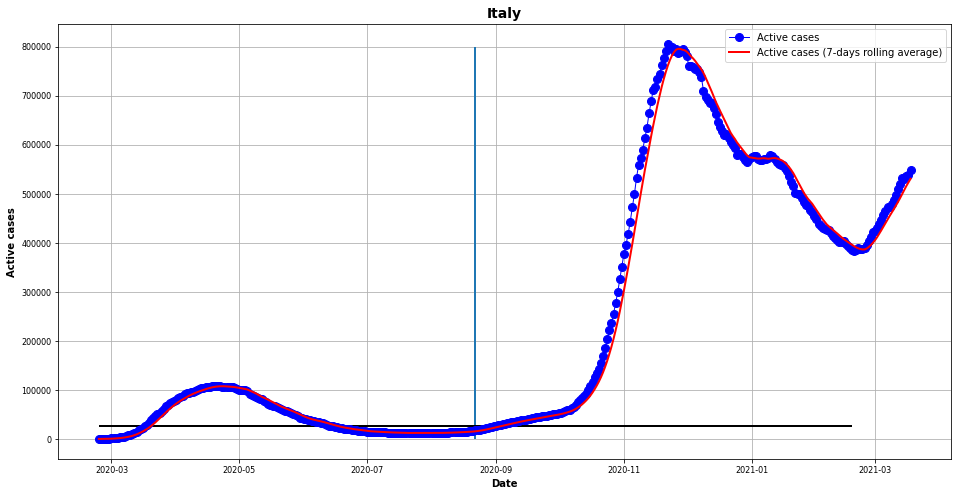

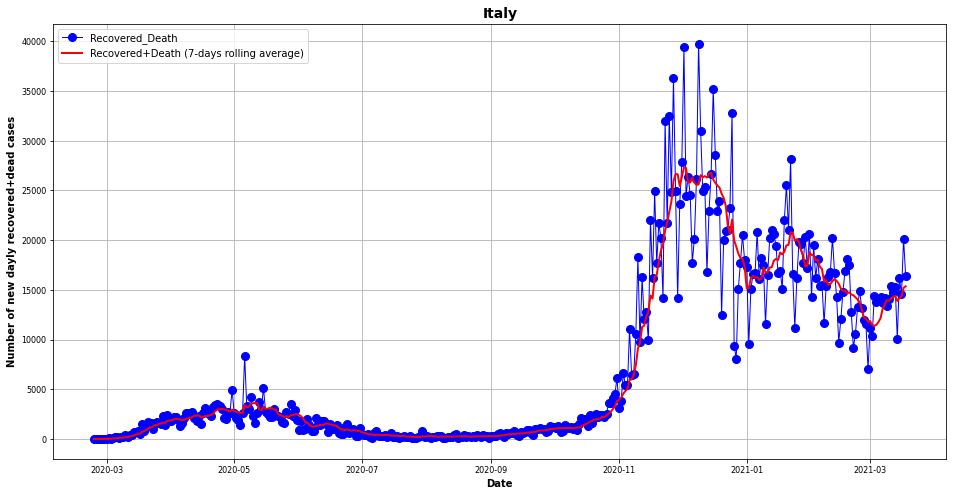

In [12]:
plt.plot(pd.to_datetime(df1.Day), df1.Confirmed, 'bo-', lw=1, label='Active cases')
plt.plot(pd.to_datetime(df1.Day), df1.Confirmed_smooth, 'r', lw=2, label='Active cases (7-days rolling average)')
plt.vlines(pd.to_datetime(df1.Day[180]), 0, 800000)
plt.hlines(df1.loc[224, 'Confirmed_smooth'] / 2, pd.to_datetime(df1.Day[0]), pd.to_datetime(df1.Day[360]), color='k')
plt.xlabel('Date')
plt.ylabel('Active cases')
plt.title('Italy', weight='bold', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("active_data_Italy.png", quality=100, transparent=True, dpi=400)
plt.show()


plt.plot(pd.to_datetime(df1.Day), df1.Recovered_Death, 'bo-', lw=1, label='Recovered_Death')
plt.plot(pd.to_datetime(df1.Day), df1.Recovered_Death_smooth, 'r', lw=2, label='Recovered+Death (7-days rolling average)')
plt.xlabel('Date')
plt.ylabel('Number of new dayly recovered+dead cases')
plt.title('Italy', weight='bold', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("recovered_death_data_Italy.png", quality=100, transparent=True, dpi=400)

In [13]:
# instantiating an analysis object
analysis_ita = Analysis(date=df1['Day'],
                        confirmed=df1['Confirmed_smooth'].to_numpy(),
                        recovered_death=df1['Recovered_Death_smooth'].to_numpy(),
                        quarantine='2020.03.09',
                        last_data='2020.04.01',
                        last_projection='2020.05.17',
                        peak='2020.04.23',
                        beta=[0,1],
                        rmu=[0,1],
                        q=[0,5],
                        p=[0,5],
                        tauI=[0.01, 0.01],
                        tauX=[0.01, 0.01],
                        country='Italy')

## Fit ending before peak data for the daily number of active cases
fit from 2020-02-24 to 2020-03-29 with confinement measure aplied on 2020-03-09

In [14]:
%%time
analysis_ita.sampler(nchains=12, nthreads=12, niter=50000, burn_in=0.5)

sampling: iterations 43699 of 600000, elapsed 0:00:07, remaining 0:01:28
sampling: iterations 294983 of 600000, elapsed 0:00:12, remaining 0:00:12
sampling: iterations 449558 of 600000, elapsed 0:00:17, remaining 0:00:06
sampling: iterations 600000 of 600000, elapsed 0:00:19, remaining 0:00:00
CPU times: user 2min 20s, sys: 5.64 s, total: 2min 25s
Wall time: 24.9 s


In [16]:
%%time

analysis_ita.summary

CPU times: user 10 s, sys: 297 ms, total: 10.3 s
Wall time: 10.3 s


median       sd  2.5%_hdi  97.5%_hdi   r_hat
beta    0.2416   0.0025    0.2368     0.2468  1.0005
rmu     0.0287   0.0019    0.0253     0.0327  1.0006
q       0.0469   0.0026    0.0434     0.0536  1.0009
p       0.0059   0.0063    0.0002     0.0233  1.0009
tauI  319.4506  79.4859  189.4441   499.3583  1.0000
tauX    6.5877   1.5852    3.9798    10.1493  1.0000

(679.2001097105489, 13584.002194210978)

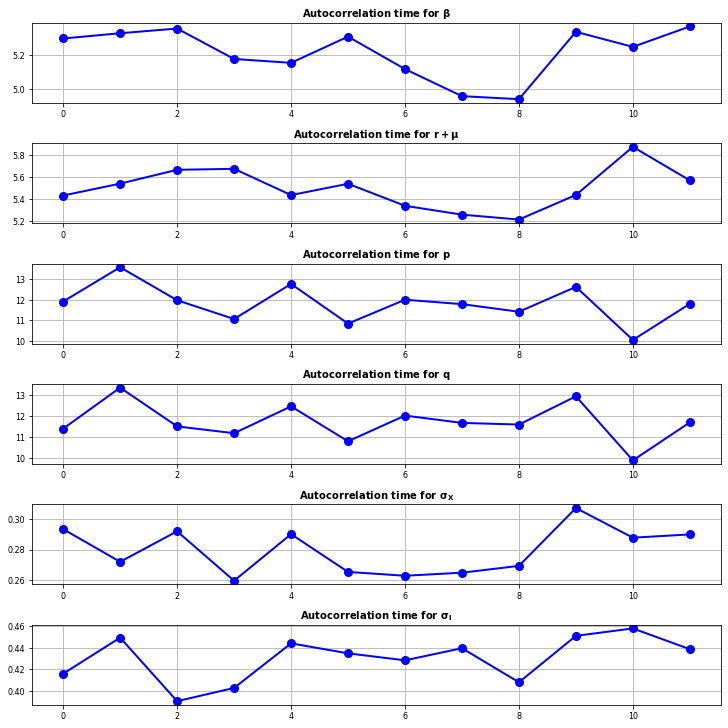

In [17]:
analysis_ita.autocorrelation_time_plot()
analysis_ita.times.max()*50, analysis_ita.times.max()*1000

### Trace, posterior distribution, autocorrelation plot before peak (Italy)

CPU times: user 6.3 s, sys: 31.2 ms, total: 6.33 s
Wall time: 6.29 s


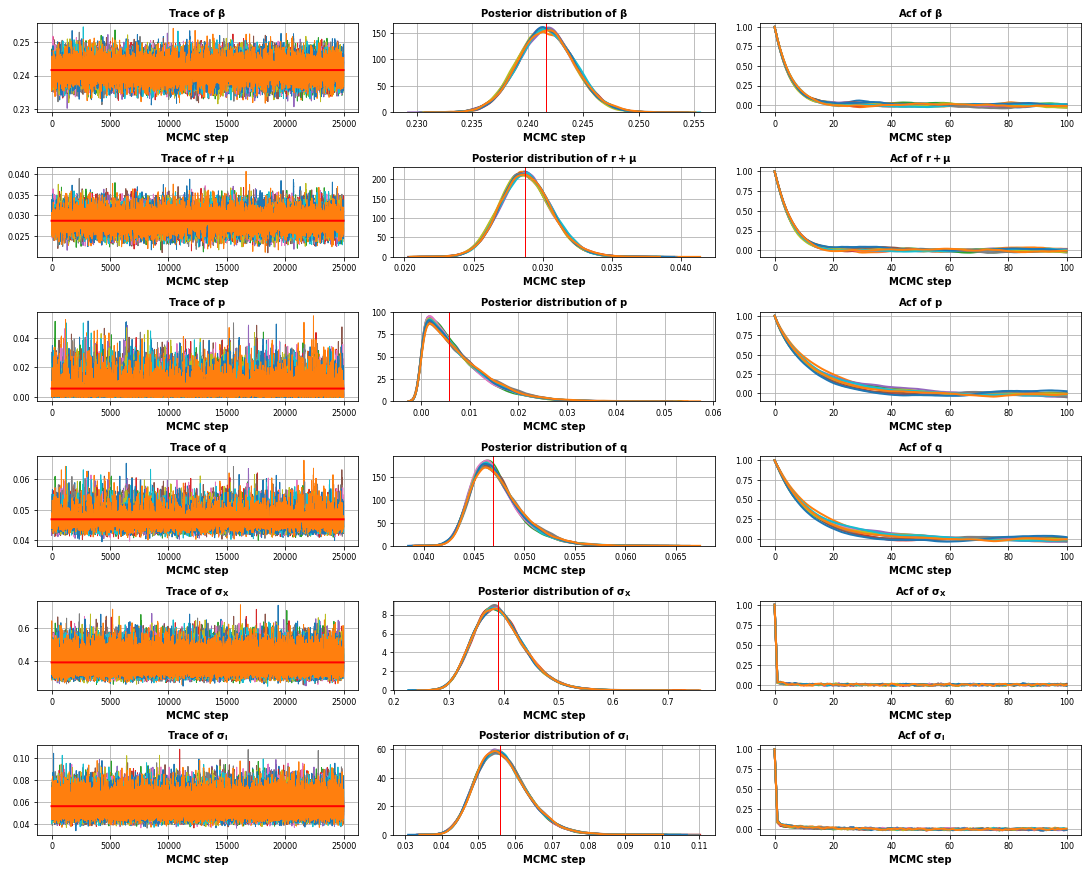

In [18]:
%%time

analysis_ita.plot_summary()

### Posterior of the time to reach the peak of the epidemic

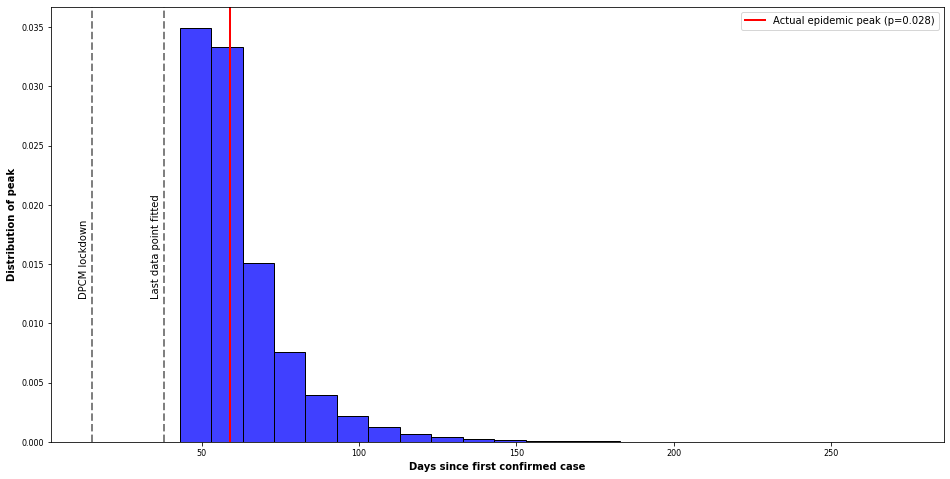

CPU times: user 250 ms, sys: 31.2 ms, total: 281 ms
Wall time: 261 ms


In [19]:
%%time

analysis_ita.peak_posterior(offset=4)
#plt.savefig("peak_posterior_Italy.png", quality=100, transparent=True, dpi=400)

### Plotting fit results before peak

fit from 2020-03-01 to 2020-03-31 with confinement measure applied on 2020-03-09

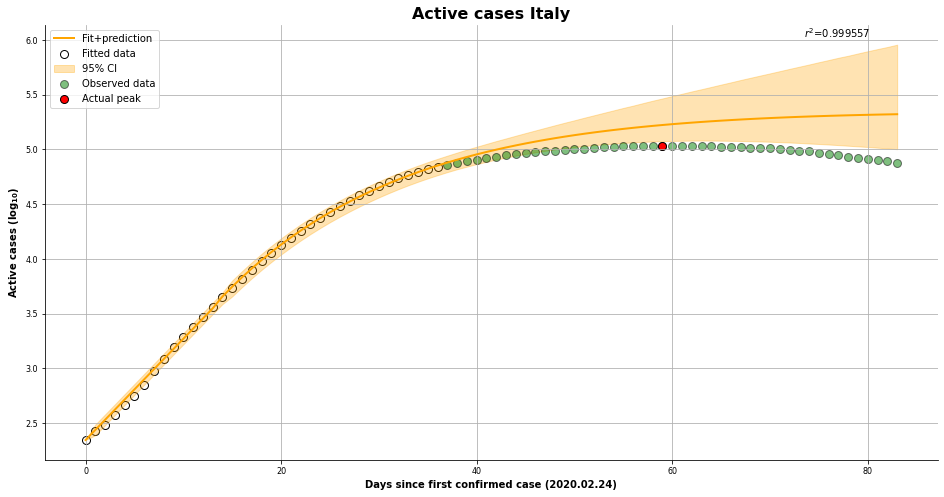

In [20]:
analysis_ita.plot_results(Y=True, observed=True)
#plt.savefig("active_cases_Italy.png", quality=100, transparent=True, dpi=400)

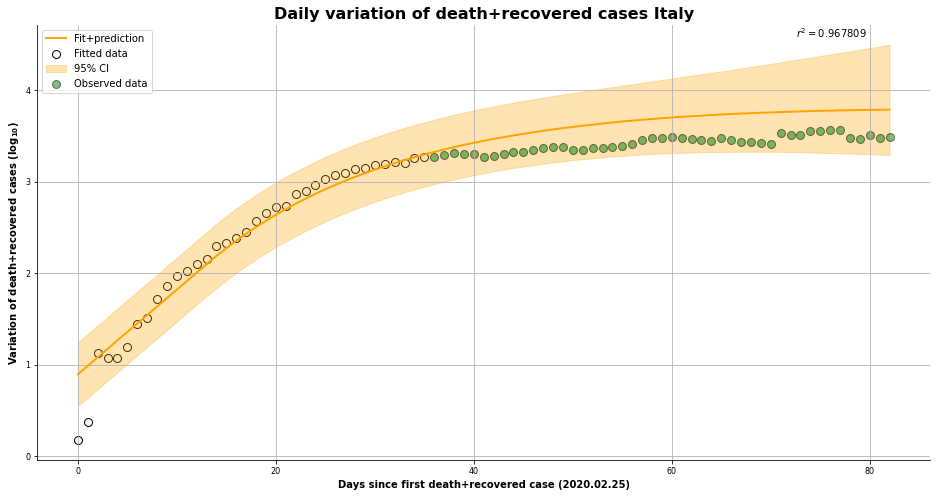

In [21]:
analysis_ita.plot_results(Z=True, observed=True)
#plt.savefig("death_recovered_Italy.png", quality=100, transparent=True, dpi=400)

## Fit ending after peak data for the daily number of active cases

In [6]:
analysis_ita_2 = Analysis(date=df1['Day'],
                          confirmed=df1['Confirmed_smooth'].to_numpy(),
                          recovered_death=df1['Recovered_Death_smooth'].to_numpy(),
                          quarantine='2020.03.09',
                          last_data='2020.04.23',
                          last_projection='2020.07.23',
                          peak='2020.04.23',
                          beta=[0,1],
                          rmu=[0,1],
                          q=[0,5],
                          p=[0,5],
                          tauI=[0.01, 0.01],
                          tauX=[0.01, 0.01],
                          country='Italy')

In [7]:
%%time

analysis_ita_2.sampler(nchains=12, nthreads=12, niter=60000, burn_in=0.5)

sampling: iterations 12304 of 720000, elapsed 0:00:06, remaining 0:06:06
sampling: iterations 86522 of 720000, elapsed 0:00:11, remaining 0:01:23
sampling: iterations 184009 of 720000, elapsed 0:00:16, remaining 0:00:48
sampling: iterations 252928 of 720000, elapsed 0:00:22, remaining 0:00:40
sampling: iterations 332513 of 720000, elapsed 0:00:27, remaining 0:00:31
sampling: iterations 401079 of 720000, elapsed 0:00:32, remaining 0:00:26
sampling: iterations 469068 of 720000, elapsed 0:00:37, remaining 0:00:20
sampling: iterations 542333 of 720000, elapsed 0:00:43, remaining 0:00:14
sampling: iterations 610102 of 720000, elapsed 0:00:48, remaining 0:00:09
sampling: iterations 691817 of 720000, elapsed 0:00:53, remaining 0:00:02
sampling: iterations 720000 of 720000, elapsed 0:00:55, remaining 0:00:00
CPU times: user 6min 54s, sys: 16.5 s, total: 7min 11s
Wall time: 1min 11s


In [8]:
%%time

analysis_ita_2.summary

CPU times: user 15.5 s, sys: 828 ms, total: 16.4 s
Wall time: 16.4 s


median       sd  2.5%_hdi  97.5%_hdi   r_hat
beta    0.2436   0.0954    0.2400     0.6220  1.2171
rmu     0.0275   0.0961    0.0252     0.4090  1.2177
q       0.0492   0.0084    0.0175     0.0508  1.2173
p       0.0003   0.0062    0.0000     0.0240  1.2146
tauI  349.7870  72.5106  232.1892   516.6777  1.0538
tauX    9.2872   3.1289    0.1269    13.3518  1.2126

(441591.1616194911, 8831823.232389823)

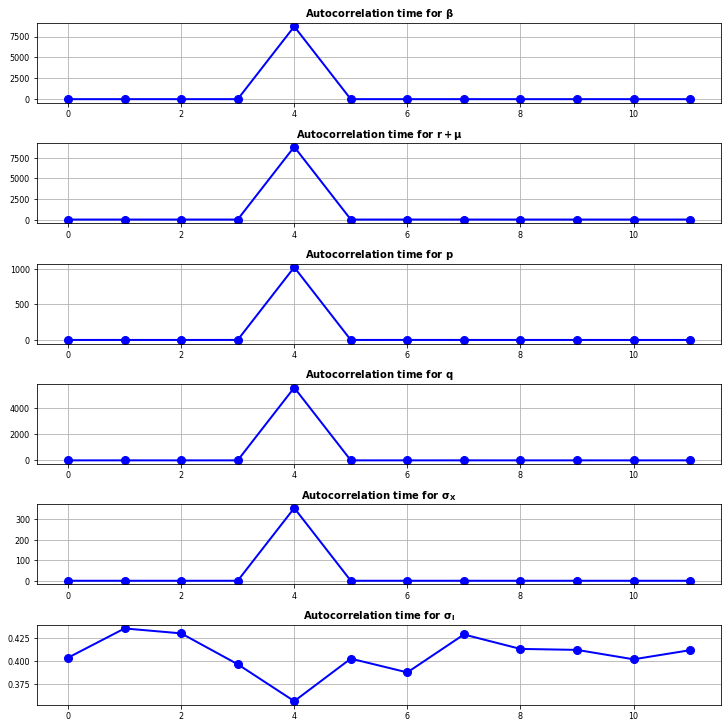

In [11]:
analysis_ita_2.autocorrelation_time_plot()
analysis_ita_2.times.max()*50, analysis_ita_2.times.max()*1000

### Trace, posterior distribution, autocorrelation plot after peak (Italy)

CPU times: user 7.09 s, sys: 78.1 ms, total: 7.17 s
Wall time: 7.09 s


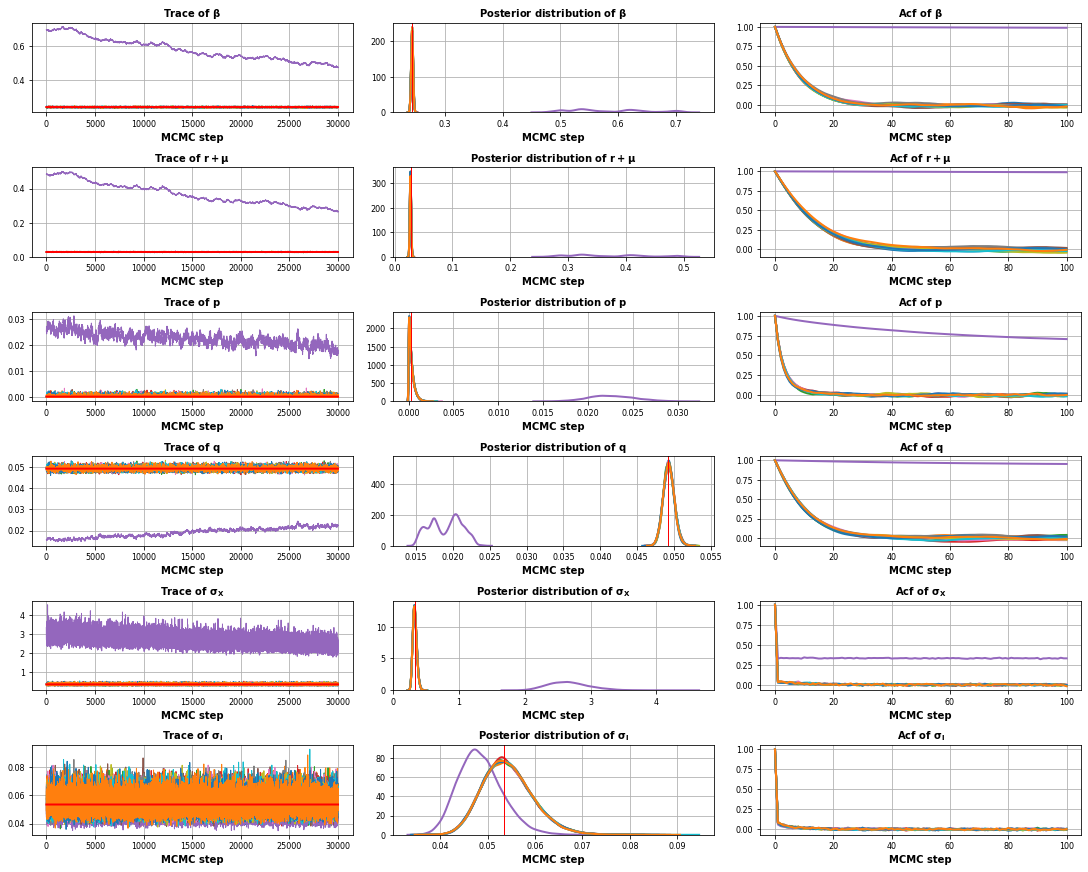

In [9]:
%%time

analysis_ita_2.plot_summary()

### Distribution of times until the number of confirmed cases falls below 1000 for the first time (Spain)

CPU times: user 3.77 s, sys: 5.81 s, total: 9.58 s
Wall time: 9.58 s


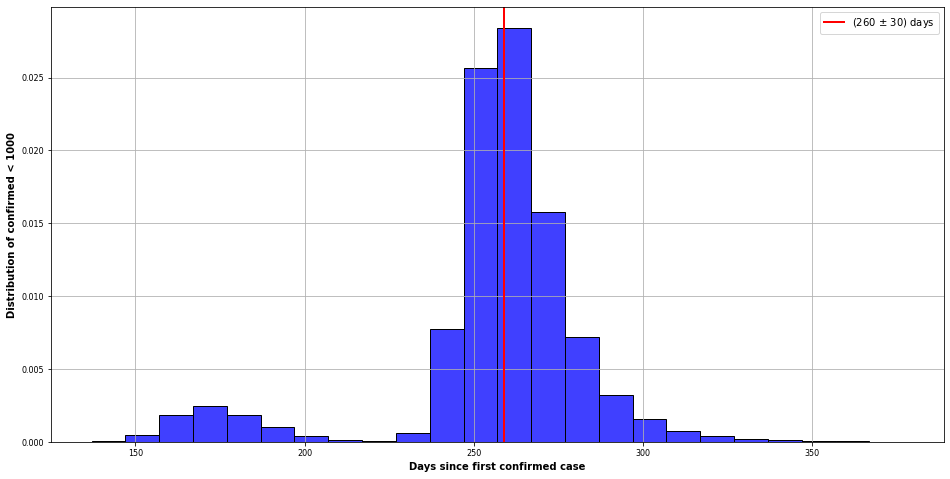

In [12]:
%%time

# 2021.03.01
analysis_ita_2.end_epidemic_plot(371)

### Plotting fit results after peak

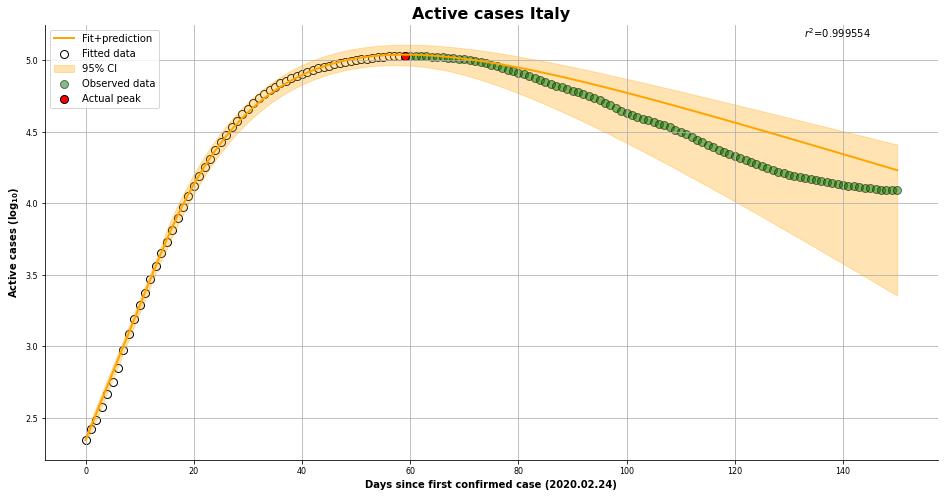

In [13]:
analysis_ita_2.plot_results(Y=True, observed=True)
#plt.xlim(-4.5, 170)
#plt.ylim(2, 6)

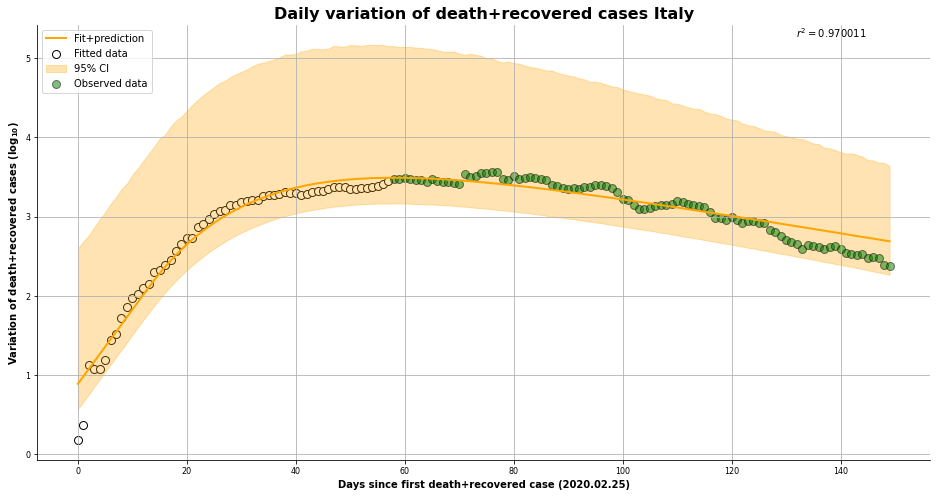

In [14]:
analysis_ita_2.plot_results(Z=True, observed=True)
#plt.xlim(-4.5, 170)
#plt.ylim(0, 6)

## Fit ending before peak data (second wave) 

In [57]:
print(df1.Confirmed_smooth.argmax())
df1.loc[df1.Day >= '2020.10.05']

277


Day  Confirmed  Recovered  Death  Confirmed_smooth  \
224  2020.10.05      58903     232681  36002      54347.857143   
225  2020.10.06      60134     234099  36030      55705.571429   
226  2020.10.07      62576     235303  36061      57321.714286   
227  2020.10.08      65952     236363  36083      59222.428571   
228  2020.10.09      70110     237549  36111      61524.285714   
..          ...        ...        ...    ...               ...   
361  2021.02.19     382448    2303199  95235     393113.285714   
362  2021.02.20     384623    2315687  95486     390714.714286   
363  2021.02.21     388895    2324633  95718     388730.714286   
364  2021.02.22     387903    2334968  95992     387274.285714   
365  2021.02.23     387948    2347866  96348     386454.571429   

     Recovered_Death  Recovered_Death_smooth  
224            783.0             1091.714286  
225           1446.0             1106.857143  
226           1235.0             1109.428571  
227           1082.0             1097.714286  
228           1214.0             1107.000000  
..               ...                     ...  
361          17523.0            14758.857143  
362          12739.0            14538.142857  
363           9178.0            14465.000000  
364          10609.0            14262.142857  
365          13254.0            14044.142857  

[142 rows x 7 columns]

In [42]:
df2 = df1.loc[df1.Day >= '2020.10.10'].reset_index(drop=True) # 2020.10.12, 2020.10.05
df2

Day  Confirmed  Recovered   Death  Confirmed_smooth  \
0    2020.10.10      74829     238525   36140      64276.142857   
1    2020.10.11      79075     239709   36166      67368.428571   
2    2020.10.12      82764     240600   36205      70777.142857   
3    2020.10.13      87193     242028   36246      74642.714286   
4    2020.10.14      92445     244065   36289      78909.714286   
..          ...        ...        ...     ...               ...   
155  2021.03.14     531266    2589731  102145     499497.714286   
156  2021.03.15     530357    2605538  102499     507758.285714   
157  2021.03.16     536115    2619654  103001     515934.285714   
158  2021.03.17     539008    2639370  103432     523353.428571   
159  2021.03.18     547510    2655346  103855     530519.142857   

     Recovered_Death  Recovered_Death_smooth  
0             1005.0             1068.571429  
1             1210.0             1139.285714  
2              930.0             1160.285714  
3             1469.0             1163.571429  
4             2080.0             1284.285714  
..               ...                     ...  
155          10099.0            13893.142857  
156          16161.0            14171.714286  
157          14618.0            14349.285714  
158          20147.0            15215.428571  
159          16399.0            15362.000000  

[160 rows x 7 columns]

In [57]:
analysis_ita_3 = Analysis(date=df2['Day'],
                          confirmed=df2['Confirmed_smooth'].to_numpy(),
                          recovered_death=df2['Recovered_Death_smooth'].to_numpy(), 
                          quarantine='2020.11.06',
                          last_data='2020.11.12',
                          last_projection='2020.12.31',
                          peak='2020.11.27',                         
                          beta=[0,1],  # try with [0, 0.2] cause here beta like 1/10
                          rmu=[0,1],   # try with [0, 0.2]
                          q=[0,5],
                          p=[0,5],
                          tauI=[0.01, 0.01],
                          tauX=[0.01, 0.01],                          
                          country='Italy')

In [58]:
%%time
analysis_ita_3.sampler(nchains=12, nthreads=12, niter=100000, burn_in=0.5)

sampling: iterations 279695 of 1200000, elapsed 0:00:07, remaining 0:00:24
sampling: iterations 670469 of 1200000, elapsed 0:00:14, remaining 0:00:11
sampling: iterations 1183972 of 1200000, elapsed 0:00:19, remaining 0:00:00
sampling: iterations 1200000 of 1200000, elapsed 0:00:19, remaining 0:00:00
CPU times: user 2min 48s, sys: 1min 1s, total: 3min 50s
Wall time: 56.3 s


In [59]:
summary = analysis_ita_3.summary
summary

median       sd  2.5%_hdi  97.5%_hdi  r_hat
beta    0.0832   0.0008    0.0816     0.0848    1.0
rmu     0.0147   0.0004    0.0141     0.0154    1.0
q       0.8701   0.5890    0.1333     2.3646    1.0
p       3.4471   1.2432    0.5610     4.9330    1.0
tauI  279.4272  72.4430  161.3373   443.2712    1.0
tauX   53.9214  13.5377   31.7627    84.4731    1.0

(111.46918051870361, 2229.383610374072)

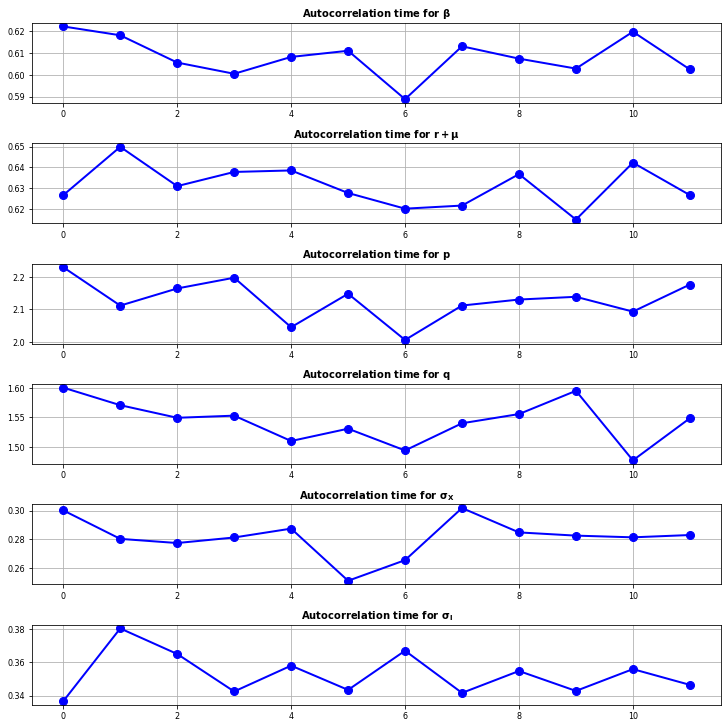

In [60]:
analysis_ita_3.autocorrelation_time_plot()
analysis_ita_3.times.max()*50, analysis_ita_3.times.max()*1000

### Trace, posterior distribution, autocorrelation plot before peak (Italy)

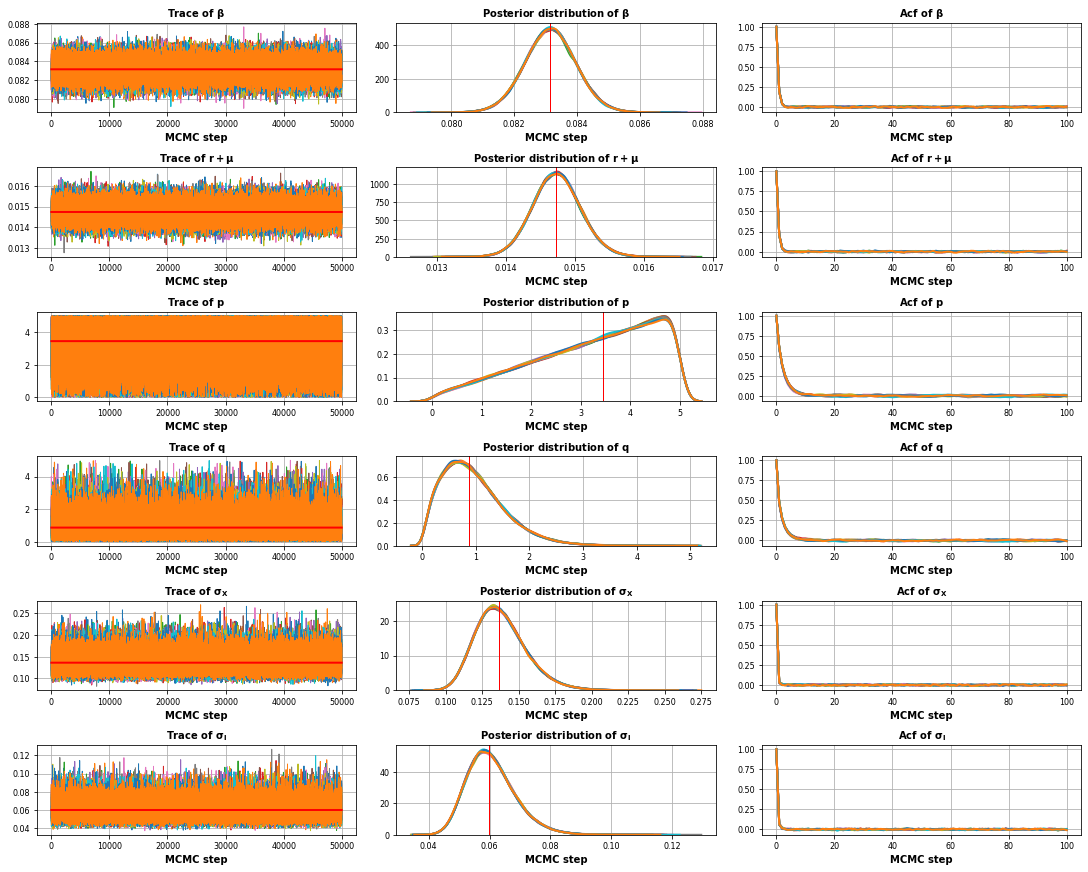

In [61]:
analysis_ita_3.plot_summary()

### Posterior of the time to reach the peak of the epidemic

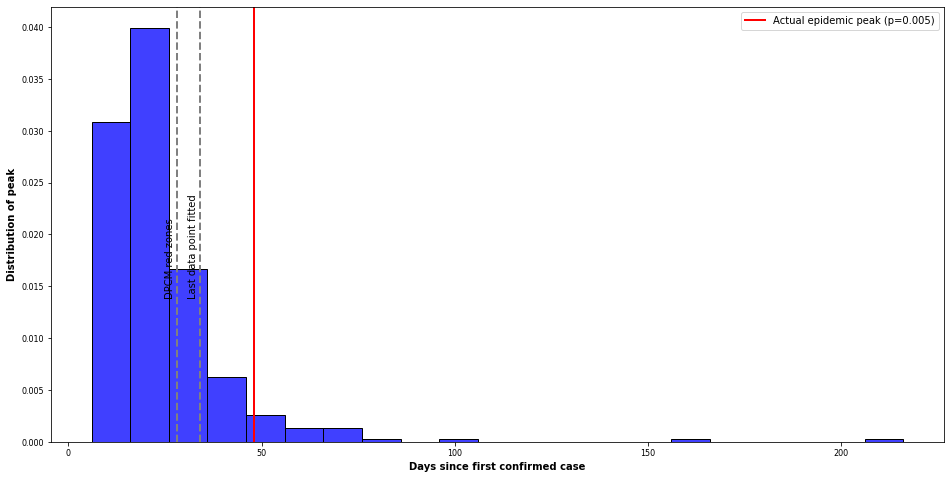

In [62]:
analysis_ita_3.peak_posterior(second_wave=True)

### Plotting fit results after peak

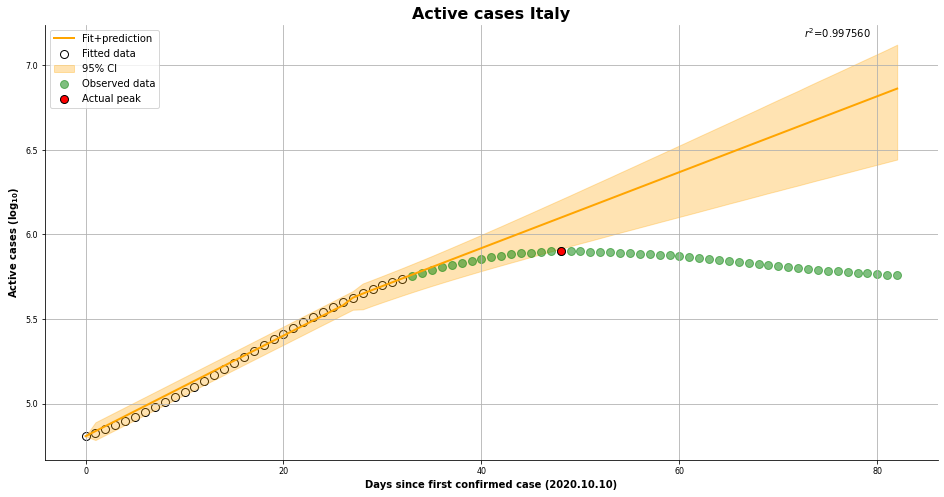

In [63]:
analysis_ita_3.plot_results(Y=True, observed=True)
#doubling_time(analysis_ita_3, tf=40, taud=10);

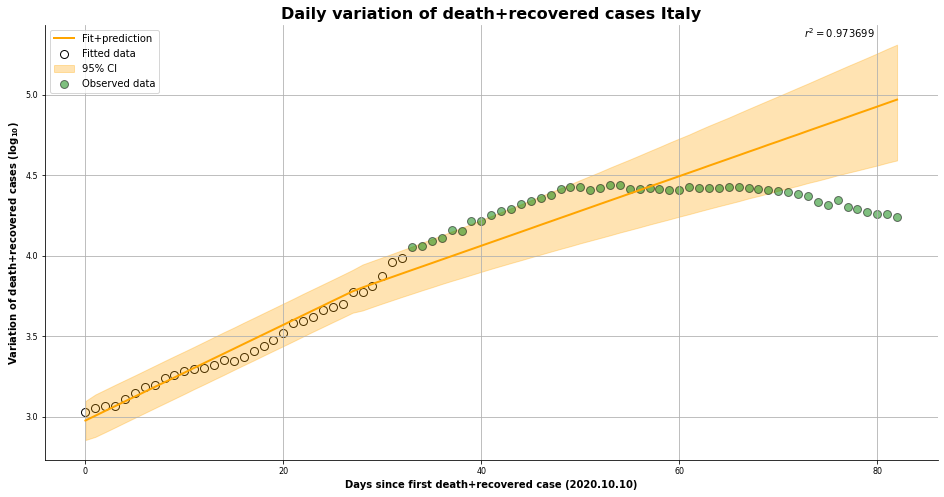

In [64]:
analysis_ita_3.plot_results(Z=True, observed=True)

In [65]:
df2

Day  Confirmed  Recovered   Death  Confirmed_smooth  \
0    2020.10.10      74829     238525   36140      64276.142857   
1    2020.10.11      79075     239709   36166      67368.428571   
2    2020.10.12      82764     240600   36205      70777.142857   
3    2020.10.13      87193     242028   36246      74642.714286   
4    2020.10.14      92445     244065   36289      78909.714286   
..          ...        ...        ...     ...               ...   
155  2021.03.14     531266    2589731  102145     499497.714286   
156  2021.03.15     530357    2605538  102499     507758.285714   
157  2021.03.16     536115    2619654  103001     515934.285714   
158  2021.03.17     539008    2639370  103432     523353.428571   
159  2021.03.18     547510    2655346  103855     530519.142857   

     Recovered_Death  Recovered_Death_smooth  
0             1005.0             1068.571429  
1             1210.0             1139.285714  
2              930.0             1160.285714  
3             1469.0             1163.571429  
4             2080.0             1284.285714  
..               ...                     ...  
155          10099.0            13893.142857  
156          16161.0            14171.714286  
157          14618.0            14349.285714  
158          20147.0            15215.428571  
159          16399.0            15362.000000  

[160 rows x 7 columns]

# Fit ending after peak data (second wave)

In [66]:
analysis_ita_4 = Analysis(date=df2['Day'],
                          confirmed=df2['Confirmed_smooth'].to_numpy(),
                          recovered_death=df2['Recovered_Death_smooth'].to_numpy(), 
                          quarantine='2020.11.06',
                          last_data='2020.11.27',
                          last_projection='2021.02.27',
                          peak='2020.11.27',
                          beta=[0,1],  # try with [0, 0.2] cause here beta like 1/10
                          rmu=[0,1],   # try with [0, 0.2]
                          q=[0,5],
                          p=[0,5],
                          tauI=[0.01, 0.01],
                          tauX=[0.01, 0.01],                            
                          country='Italy')

In [ ]:
%%time
analysis_ita_4.sampler(nchains=12, nthreads=12, niter=500000, burn_in=0.5)

sampling: iterations 62168 of 6000000, elapsed 0:00:05, remaining 0:08:24
sampling: iterations 243241 of 6000000, elapsed 0:00:10, remaining 0:04:07
sampling: iterations 403081 of 6000000, elapsed 0:00:16, remaining 0:03:35
sampling: iterations 600202 of 6000000, elapsed 0:00:21, remaining 0:03:06
sampling: iterations 761950 of 6000000, elapsed 0:00:27, remaining 0:03:03
sampling: iterations 925096 of 6000000, elapsed 0:00:32, remaining 0:02:56
sampling: iterations 1119927 of 6000000, elapsed 0:00:37, remaining 0:02:43
sampling: iterations 1332894 of 6000000, elapsed 0:00:43, remaining 0:02:30
sampling: iterations 1437508 of 6000000, elapsed 0:00:48, remaining 0:02:32
sampling: iterations 1534305 of 6000000, elapsed 0:00:54, remaining 0:02:36
sampling: iterations 1639876 of 6000000, elapsed 0:01:00, remaining 0:02:38
sampling: iterations 1851304 of 6000000, elapsed 0:01:05, remaining 0:02:25
sampling: iterations 2034616 of 6000000, elapsed 0:01:10, remaining 0:02:16
sampling: iteration

In [ ]:
analysis_ita_4.summary

(482009.5028979754, 9640190.057959508)

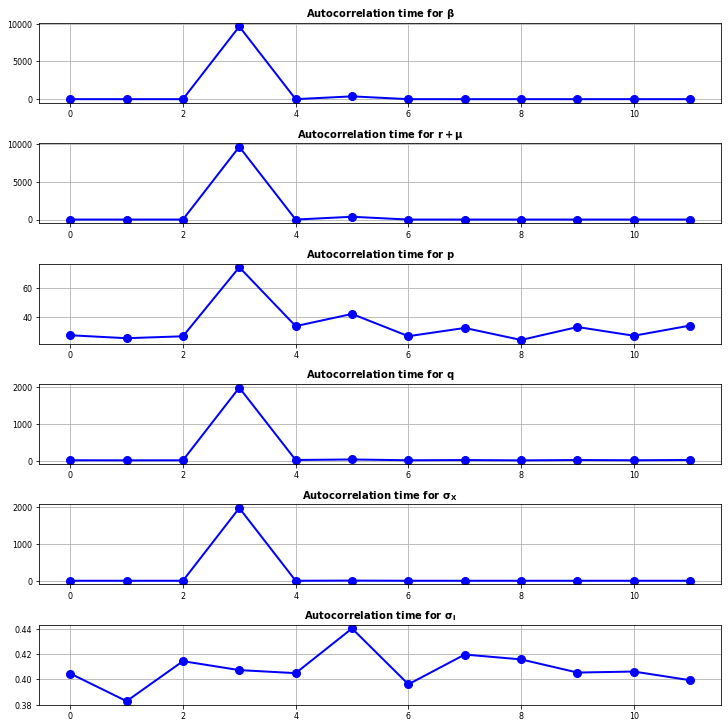

In [95]:
analysis_ita_4.autocorrelation_time_plot()
analysis_ita_4.times.max()*50, analysis_ita_4.times.max()*1000

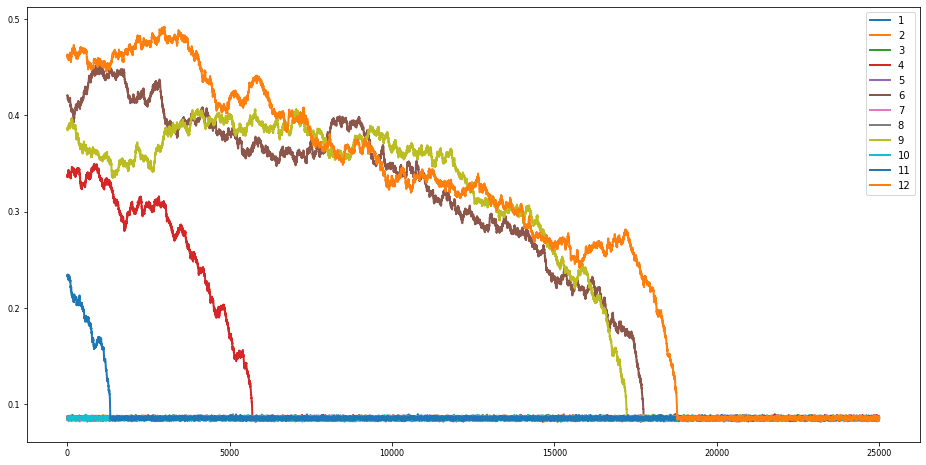

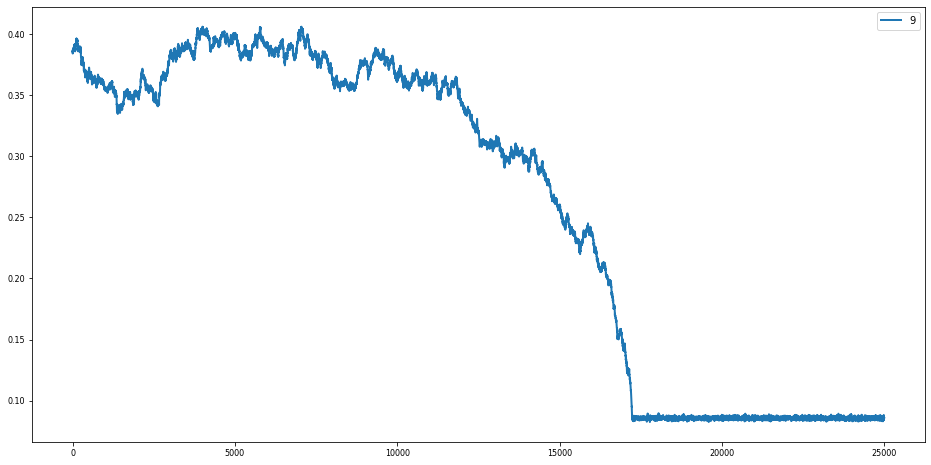

In [71]:
for i in range(analysis_ita_4.nchains):
    plt.plot(analysis_ita_4.samples['beta'][0, :, i], label=f'{i+1}')
    plt.legend()
plt.show()

i = 9
plt.plot(analysis_ita_4.samples['beta'][0, :, i-1], label=f'{i}')
plt.legend()
plt.show()

In [72]:
# Override samples after discarding samples not converged
analysis_ita_4.samples = samples_mod

NameError: name 'samples_mod' is not defined

In [73]:
for i in range(analysis_ita_4.nchains):
    plt.plot(samples_mod['tauX'][0, :, i], label=f'{i+1}')
    plt.legend()
plt.show()

NameError: name 'samples_mod' is not defined

### Trace, posterior distribution, autocorrelation plot after peak (Italy)

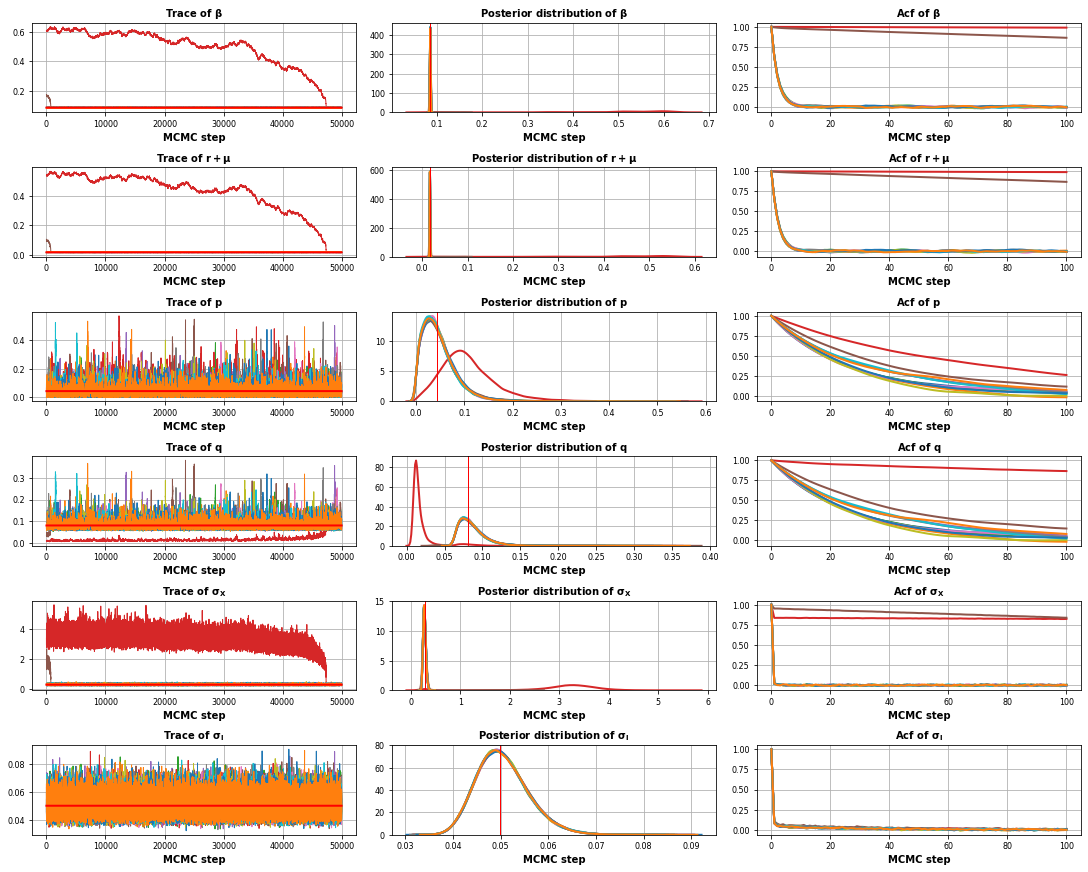

In [94]:
analysis_ita_4.plot_summary()

### Distribution of times until the number of confirmed cases falls below 1000 for the first time

CPU times: user 750 ms, sys: 0 ns, total: 750 ms
Wall time: 746 ms


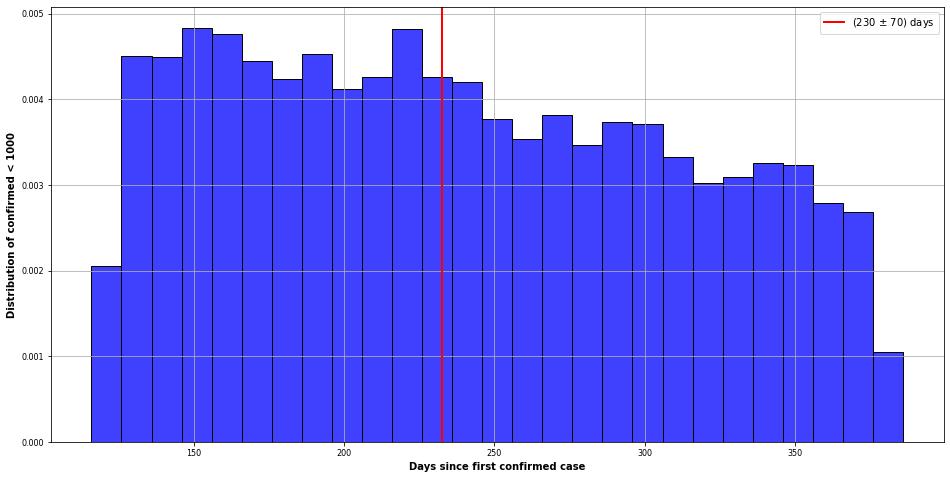

In [75]:
%%time

analysis_ita_4.end_epidemic_plot()

### Plotting fit results after peak

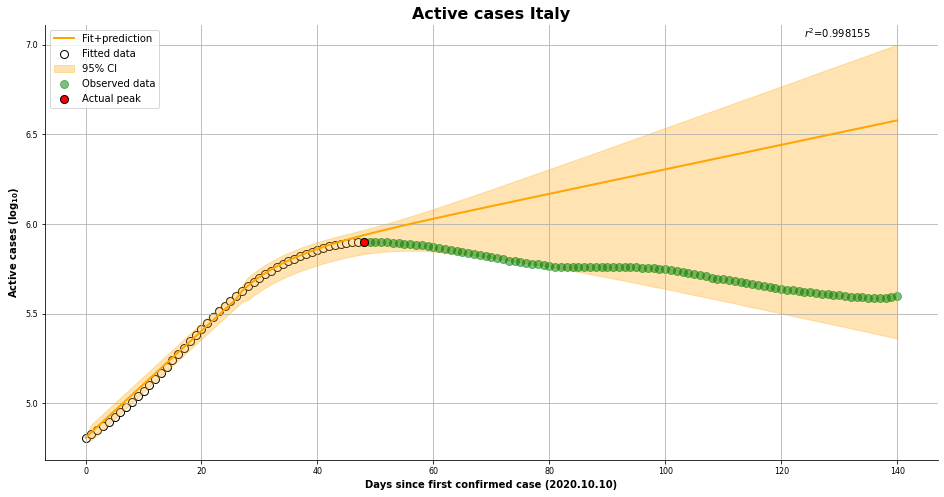

In [85]:
analysis_ita_4.plot_results(Y=True, observed=True)
#plt.xlim(-4.5, 140)
#plt.ylim(4.5, 7)

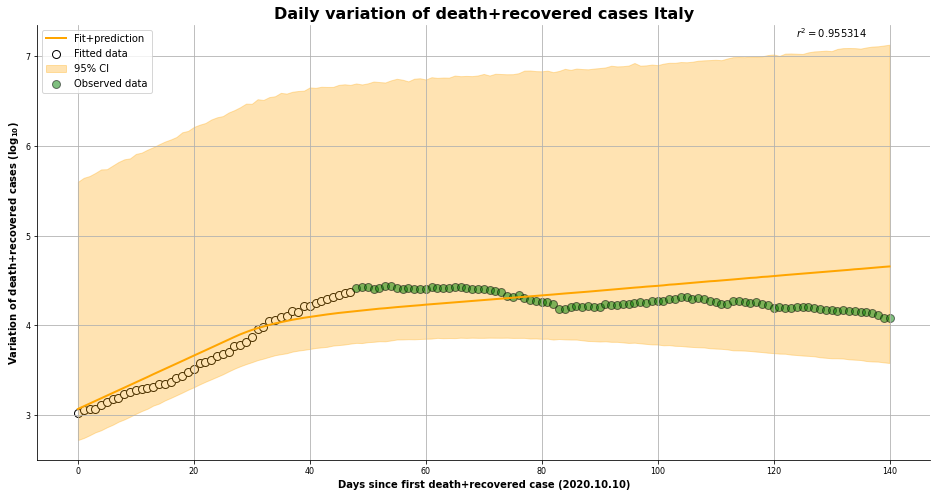

In [86]:
analysis_ita_4.plot_results(Z=True, observed=True)
#plt.xlim(-4.5, 140)
#plt.ylim(2, 6)

# Fit ending 3 weeks after peak data (second wave)

In [78]:
analysis_ita_5 = Analysis(date=df2['Day'],
                          confirmed=df2['Confirmed_smooth'].to_numpy(),
                          recovered_death=df2['Recovered_Death_smooth'].to_numpy(), 
                          quarantine='2020.11.06',
                          last_data='2020.12.18',
                          last_projection='2021.02.27',
                          peak='2020.11.27',
                          beta=[0,1],  # try with [0, 0.2] cause here beta like 1/10
                          rmu=[0,1],   # try with [0, 0.2]
                          q=[0,5],
                          p=[0,5],
                          tauI=[0.01, 0.01],
                          tauX=[0.01, 0.01],                          
                          country='Italy')

In [81]:
%%time
analysis_ita_5.sampler(nchains=12, nthreads=12, niter=60000, burn_in=0.5)

sampling: iterations 16436 of 720000, elapsed 0:00:05, remaining 0:03:38
sampling: iterations 136893 of 720000, elapsed 0:00:10, remaining 0:00:44
sampling: iterations 260051 of 720000, elapsed 0:00:16, remaining 0:00:28
sampling: iterations 360437 of 720000, elapsed 0:00:21, remaining 0:00:21
sampling: iterations 468294 of 720000, elapsed 0:00:26, remaining 0:00:14
sampling: iterations 579410 of 720000, elapsed 0:00:31, remaining 0:00:08
sampling: iterations 686295 of 720000, elapsed 0:00:37, remaining 0:00:02
sampling: iterations 720000 of 720000, elapsed 0:00:38, remaining 0:00:00
CPU times: user 6min 51s, sys: 27.1 s, total: 7min 18s
Wall time: 1min 2s


In [82]:
analysis_ita_5.summary

median        sd  2.5%_hdi  97.5%_hdi   r_hat
beta    0.1791    0.1718    0.0885     0.6196  2.2015
rmu     0.1107    0.1719    0.0202     0.5513  2.2018
q       0.0293    0.0235    0.0085     0.0651  2.1886
p       0.0255    0.0204    0.0001     0.0515  1.8160
tauI  571.3710  100.9792  396.8919   791.6529  1.0021
tauX    0.3578    3.0300    0.0836     7.8277  1.9596

(38419.14249457055, 768382.849891411)

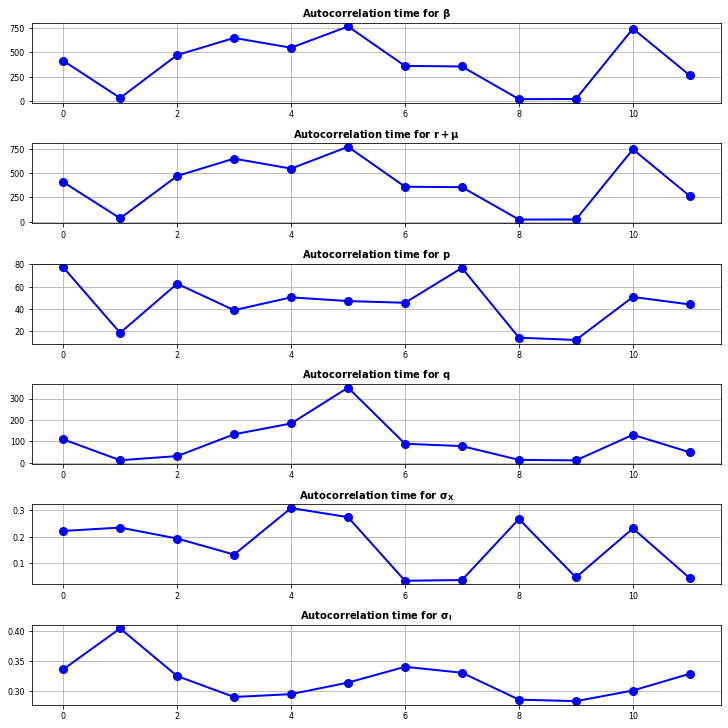

In [298]:
analysis_ita_5.autocorrelation_time_plot()
analysis_ita_5.times.max()*50, analysis_ita_5.times.max()*1000

### Trace, posterior distribution, autocorrelation plot after peak (Italy)

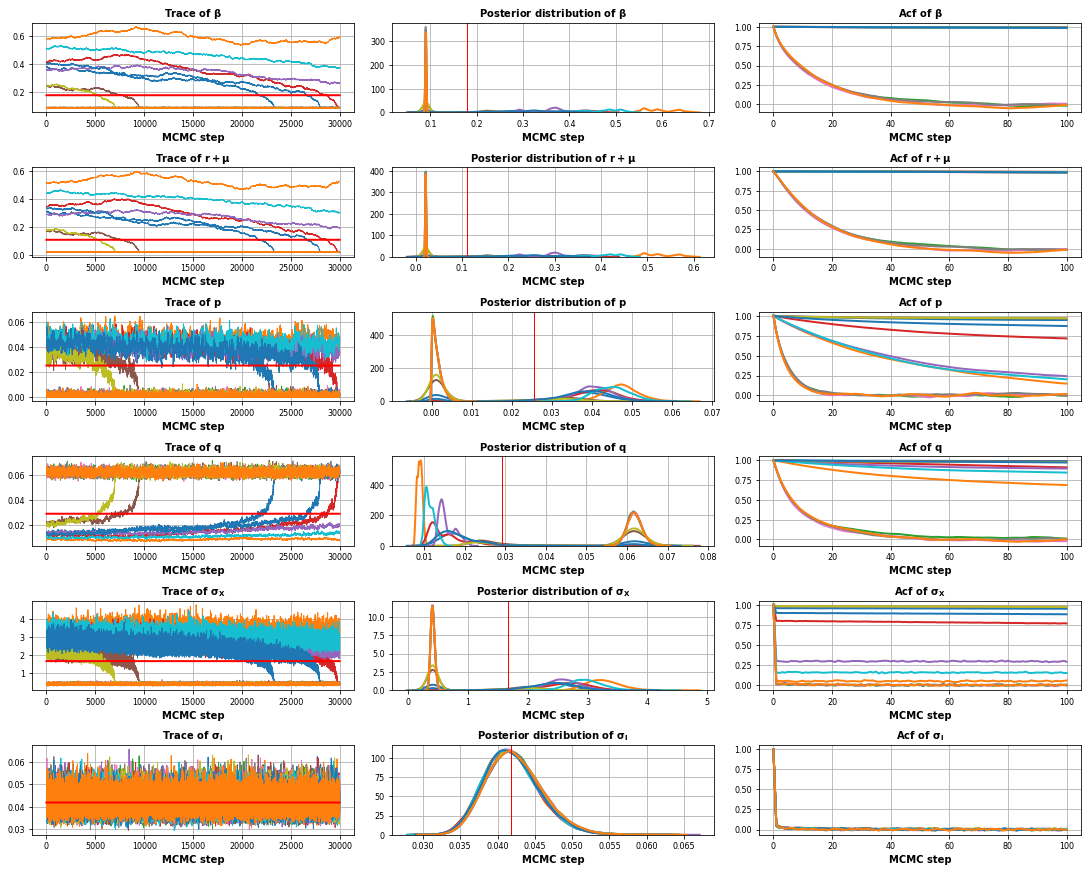

In [87]:
analysis_ita_5.plot_summary()

### Distribution of times until the number of confirmed cases falls below 1000 for the first time

CPU times: user 4.31 s, sys: 5.19 s, total: 9.5 s
Wall time: 9.34 s


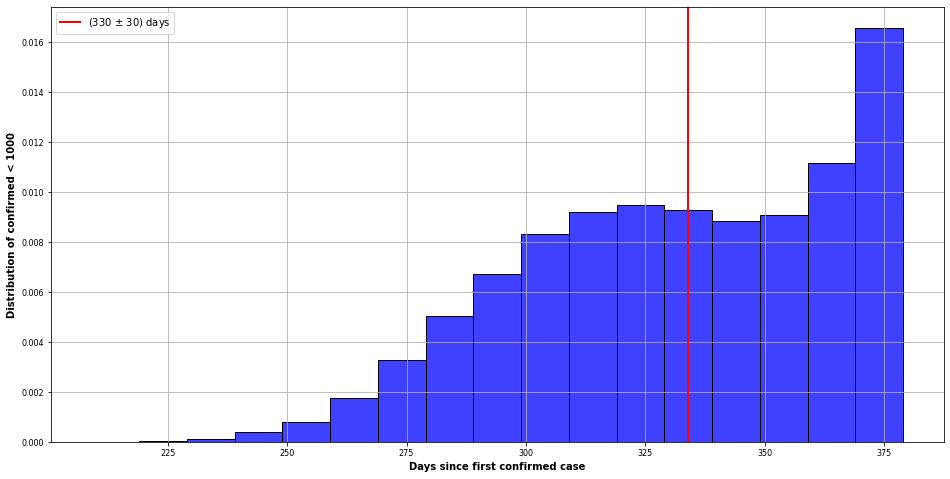

In [88]:
%%time

analysis_ita_5.end_epidemic_plot()

### Plotting fit results after peak

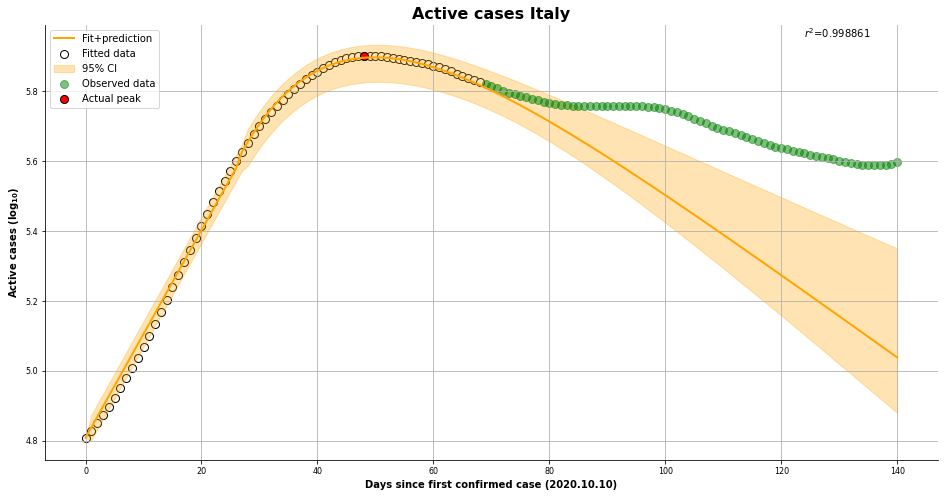

In [90]:
analysis_ita_5.plot_results(Y=True, observed=True)
#plt.xlim(-4.5, 140)
#plt.ylim(4.5, 6)

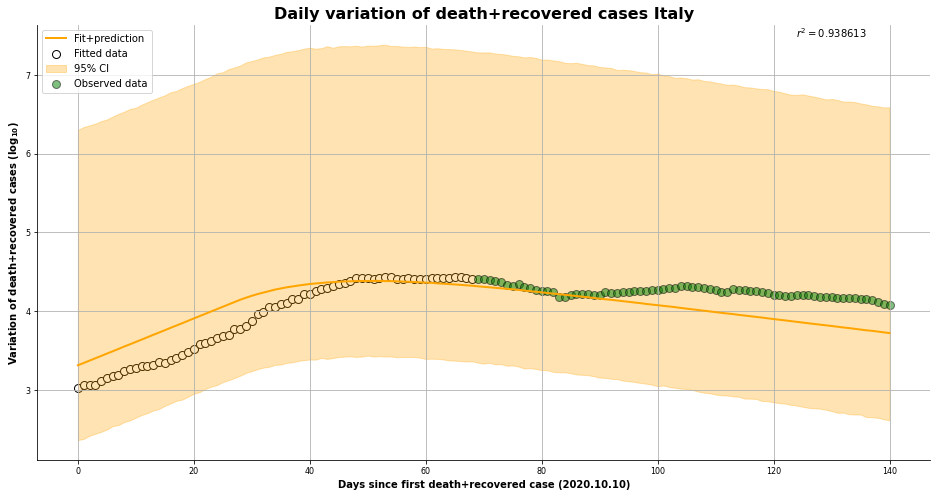

In [91]:
analysis_ita_5.plot_results(Z=True, observed=True)
#plt.xlim(-4.5, 140)
#plt.ylim(2, 6)

# References

1. articolo: https://arxiv.org/abs/2004.08842
    1. article [repository](https://github.com/mariocastro73/predictability)
    2. ref [5](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7190554/) 
    
2. sito Ministero della salute Spagnolo: https://www.mscbs.gob.es/
3. JAGS: https://web.sgh.waw.pl/~atoroj/ekonometria_bayesowska/jags_user_manual.pdf
4. pyJAGS: https://github.com/michaelnowotny/pyjags
5. Dati COVID-19 Italia (Protezione Civile): https://github.com/pcm-dpc/COVID-19
6. Data officially reported by Spanish Ministry of Health and curated by DATADISTA: 
<br> https://github.com/datadista/datasets/tree/master/COVID%2019/old_series
7. Updated Datasets (post-peak data), officially reported by Spanish Ministry of Health and curated by El-Pais-Data by late July, 2020:  
https://www.epdata.es/datos/coronavirus-china-datos-graficos/498

8. How to [scrape](https://medium.com/@sateesh.gmc/how-to-scrape-wikipedia-table-using-python-beautiful-soup-cd0d8ee1a319) wikipedia (non usato perché si può fare con la libreria wikipedia, ma da jupyter non sembra funzionare, solo da terminale)
* Da consultare per motivare il doubling time
    * [Plotting1](https://scipython.com/blog/plotting-covid-19-case-growth-charts/) COVID-19 case growth
    * [Plotting2](https://scipython.com/blog/plotting-covid-19-case-growth-charts/) COVID-19 case growth
    [github](https://github.com/xnx/covid-19)
